In [ ]:
!pip install --upgrade pip

In [2]:
!pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 38.8 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 38.2 MB/s  0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandas]2m3/4 [pandas]


In [3]:
!pip install joblib
!pip install scikit-learn

  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl (8.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 43.8 MB/s  0:00:00 eta 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


In [ ]:
# =========================
# STEP 0 — Setup (no histograms; removed Abs_Burst_Peak_List)
# =========================
# Optional installs (only if missing):
# pip install numpy pandas scikit-learn xgboost lightgbm joblib pyarrow fastparquet

import os, re, ast, json, math, joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight

# ---- Paths / config ----
DATA_PATH = "/Users/rohan/Documents/Research/distrubution_data_ml/Compiled_Networks.csv"
LABEL_COL = "NeuronType"

# ONLY these four list columns now (Abs_Burst_Peak_List removed)
columns_to_process = [
    "Burst_Peak_List",
    "Burst_Times_List",      # used for timing, L, bursts/min
    "IBI_List",
    "SpikesPerBurst_List",
]

TIME_COL = "Burst_Times_List"

assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

# Each row = a recording (no unique id present) → synthesize one
df = df.reset_index(drop=True)
df["recording_id"] = [f"row_{i:06d}" for i in range(len(df))]

# Sanity checks
missing = [c for c in [LABEL_COL] + columns_to_process if c not in df.columns]
assert not missing, f"Missing columns in CSV: {missing}"

df[[LABEL_COL] + columns_to_process].head()


NeuronType                                    Burst_Peak_List  \
0     MxHEMI  14.6441,3.9478,2.4697,4.4859,3.7445,1.552,1.52...   
1       MxWT                                             8.4741   
2      FxHET                        1.4235,6.7396,6.7726,6.6778   
3     MxHEMI  12.4079,2.199,6.2069,4.4418,1.8126,1.8054,3.72...   
4       MxWT                                             8.3836   

                                    Burst_Times_List  \
0  0.5,0.4,0.5,0.4,0.5,0.6,0.5,0.7,0.5,0.6,0.6,0....   
1                                                0.5   
2                                    0.6,0.5,0.4,0.5   
3  0.5,0.7,0.4,0.4,0.4,0.7,0.6,0.5,0.5,0.5,0.6,0....   
4                                                0.5   

                                            IBI_List  \
0  21,7.9,21.8,13.3,5.1,11.3,13.7,24.3,22.2,3.3,3...   
1                                                NaN   
2                                        7.1,83,85.4   
3  24.5,25.7,16.4,5.3,25.2,15.3,14.6,21.5,23.3,17...   
4                                                NaN   

                                 SpikesPerBurst_List  
0  7349,1673,1135,1915,1842,839,740,1049,7600,850...  
1                                               4043  
2                                 814,3286,2860,3139  
3  6015,1387,2649,1885,762,1115,2030,5998,886,172...  
4                                               4153

In [5]:
# ---- Input paths ----
DATA_PATH = "/Users/rohan/Documents/Research/distrubution_data_ml/Compiled_Networks.csv"

In [6]:
df = pd.read_csv(DATA_PATH)
df.head()

Run_ID  DIV          Assay  Well NeuronType                  Time Chip_ID  \
0       6    5  Network Today     1     MxHEMI  20-May-2024 10:06:26  M07039   
1       6    5  Network Today     2       MxWT  20-May-2024 10:06:26  M07039   
2       6    5  Network Today     3      FxHET  20-May-2024 10:06:26  M07039   
3       6    5  Network Today     4     MxHEMI  20-May-2024 10:06:26  M07039   
4       6    5  Network Today     5       MxWT  20-May-2024 10:06:26  M07039   

    mean_IBI    cov_IBI  mean_Burst_Peak  ...  LogISI_NumBursts  \
0  15.447368  61.446644         4.364867  ...                 3   
1        NaN        NaN         8.474121  ...                 1   
2  58.500000  76.119449         5.403383  ...                 3   
3  22.025000  56.108645         5.103559  ...                 3   
4        NaN        NaN         8.383602  ...                 1   

   LogISI_MeanBurstDur  LogISI_CV_BurstDur  LogISI_MeanSpikes  \
0             0.701933           14.475910          14.611772   
1             0.344000            0.000000           8.474121   
2             0.268267            9.218217           6.730021   
3             0.650600            6.362262          12.529625   
4             0.441900            0.000000           8.383602   

   LogISI_CV_Spikes  LogISI_MeanIBI  LogISI_CV_IBI  LogISI_BurstIBIList  \
0          3.712001        91.68895      41.539625     118.6207,64.7572   
1          0.000000             NaN            NaN                  NaN   
2          0.715162        84.18560       2.008796      82.9898,85.3814   
3          0.861041       123.06435       4.469738    126.9539,119.1748   
4          0.000000             NaN            NaN                  NaN   

         LogISI_BurstPeaks  LogISI_BurstDuration  
0   14.6441,15.1373,14.054  0.7291,0.5895,0.7872  
1                   8.4741                 0.344  
2     6.7396,6.7726,6.6778   0.2911,0.242,0.2717  
3  12.4079,12.6135,12.5674  0.6474,0.6935,0.6109  
4                   8.3836                0.4419  

[5 rows x 35 columns]

In [7]:
# =========================
# STEP 1 — Parse list columns into numeric arrays (robust to missing 'recording_id')
# =========================
import ast, re
import numpy as np
import pandas as pd

def parse_list_cell(x):
    if pd.isna(x):
        return np.array([], dtype=float)
    if isinstance(x, (list, tuple, np.ndarray)):
        return np.array(x, dtype=float)
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.array([], dtype=float)
    # Try Python/JSON literal like "[1,2,3]"
    try:
        v = ast.literal_eval(s)
        if isinstance(v, (list, tuple, np.ndarray)):
            return np.array(v, dtype=float)
    except Exception:
        pass
    # Fallback: comma/space separated
    try:
        toks = [t for t in re.split(r"[,\s]+", s) if t != ""]
        return np.array([float(t) for t in toks], dtype=float)
    except Exception:
        return np.array([], dtype=float)

# --- normalize and find/standardize 'recording_id' ---
norm_map = {c.lower().strip(): c for c in df.columns}
candidate_keys = [
    "recording_id", "recordingid", "rec_id", "record_id", "recordid",
    "recording id", "record id", "recording"  # last two are looser matches
]
rec_col = None
for k in candidate_keys:
    if k in norm_map:
        rec_col = norm_map[k]
        break

df = df.copy()
if rec_col is None:
    # No recording id present — create one
    df["recording_id"] = np.arange(len(df))
else:
    if rec_col != "recording_id":
        df.rename(columns={rec_col: "recording_id"}, inplace=True)

# --- make sure columns_to_process exists and only includes present columns ---
# (If columns_to_process already defined earlier, this just filters it.)
present_cols = [c for c in columns_to_process if c in df.columns]
missing_cols = [c for c in columns_to_process if c not in df.columns]
if missing_cols:
    print(f"[WARN] Skipping missing columns: {missing_cols}")

# --- parse the list-like columns ---
parsed = {c: [] for c in present_cols}
rec_ids = df["recording_id"].tolist()

for _, row in df.iterrows():
    for c in present_cols:
        parsed[c].append(parse_list_cell(row[c]))


# Printing the above changes

In [8]:
# --- parse the list-like columns ---
parsed = {c: [] for c in present_cols}
rec_ids = df["recording_id"].tolist()

for _, row in df.iterrows():
    for c in present_cols:
        parsed[c].append(parse_list_cell(row[c]))

# --- print parsed results for inspection ---
for i, rec_id in enumerate(rec_ids[:5]):  # limit to first 5 rows so output isn’t huge
    print(f"\nRecording ID: {rec_id}")
    for c in present_cols:
        print(f"  {c}: {parsed[c][i]}")



Recording ID: 0
  Burst_Peak_List: [14.6441  3.9478  2.4697  4.4859  3.7445  1.552   1.5271  1.6109 15.1373
  1.586   2.8479 14.054   1.7745  2.7933  2.745   1.5677  2.3139  2.0387
  5.0763  1.3808]
  Burst_Times_List: [0.5 0.4 0.5 0.4 0.5 0.6 0.5 0.7 0.5 0.6 0.6 0.5 0.6 0.4 0.5 0.8 0.6 0.6
 0.5 0.7]
  IBI_List: [21.   7.9 21.8 13.3  5.1 11.3 13.7 24.3 22.2  3.3 39.5 15.2 17.2 32.1
 10.3  4.3 10.9  9.2 10.9]
  SpikesPerBurst_List: [7349. 1673. 1135. 1915. 1842.  839.  740. 1049. 7600.  850. 1589. 7060.
  998. 1223. 1335. 1135. 1287. 1110. 2473.  866.]

Recording ID: 1
  Burst_Peak_List: [8.4741]
  Burst_Times_List: [0.5]
  IBI_List: []
  SpikesPerBurst_List: [4043.]

Recording ID: 2
  Burst_Peak_List: [1.4235 6.7396 6.7726 6.6778]
  Burst_Times_List: [0.6 0.5 0.4 0.5]
  IBI_List: [ 7.1 83.  85.4]
  SpikesPerBurst_List: [ 814. 3286. 2860. 3139.]

Recording ID: 3
  Burst_Peak_List: [12.4079  2.199   6.2069  4.4418  1.8126  1.8054  3.7206 12.6135  1.7356
  3.6186  1.3863 12.5674  1.8306]

In [9]:
# Remove histograms and re run the model to see if there is an improvement first burst time and last burst time

In [10]:
# # =========================
# # STEP 2 — Global histogram bins per feature
# # =========================
# def global_edges(all_arrays, n_bins=N_BINS):
#     """
#     Build a single set of histogram bin edges for one feature,
#     shared by ALL recordings. This lets every recording's histogram
#     be comparable (same bin edges for everyone).

#     Parameters
#     ----------
#     all_arrays : list[np.ndarray]
#         For one feature (e.g., IBI_List), this is a list of 1D arrays,
#         one array per recording.
#     n_bins : int
#         Number of histogram bins to produce.

#     Returns
#     -------
#     np.ndarray
#         Array of length (n_bins + 1) with bin edges (monotonically increasing).
#     """
#     # Keep only proper, non-empty numpy arrays (skip Nones/empties)
#     vals = [a for a in all_arrays if isinstance(a, np.ndarray) and a.size]
#     if not vals:
#         # If literally no data at all for this feature, return a safe default
#         # edges from 0 to 1 split into n_bins bins.
#         return np.linspace(0, 1, n_bins + 1)

#     # Concatenate values from all recordings to find a global min/max range
#     concat = np.concatenate(vals)

#     # Compute global min/max while ignoring NaNs
#     vmin, vmax = float(np.nanmin(concat)), float(np.nanmax(concat))

#     # If min/max are not finite (all NaNs?) or equal (constant feature),
#     # build a small padded range so bins aren't degenerate
#     if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
#         # Fallback to a basic 0..1 range if min/max are not finite
#         vmin = vmin if np.isfinite(vmin) else 0.0
#         vmax = vmax if np.isfinite(vmax) else 1.0
#         # Add a tiny pad on both sides so we can still create n_bins intervals
#         return np.linspace(vmin - 0.5, vmax + 0.5, n_bins + 1)

#     # Normal case: equal-width bins spanning [vmin, vmax]
#     return np.linspace(vmin, vmax, n_bins + 1)

# # Build a dict: for each feature column, compute its shared bin edges once.
# # Example: hist_bins["IBI_List"] is a 1D array of edges used for that feature's histograms.
# hist_bins = {c: global_edges(parsed[c], N_BINS) for c in columns_to_process}


In [9]:
# =========================
# STEP 3 — Feature helpers (robust stats only)
# =========================
def median_absolute_deviation(x):
    if x.size == 0:
        return np.nan
    med = np.nanmedian(x)
    return float(np.nanmedian(np.abs(x - med)))

def robust_stats(x):
    if x.size == 0:
        return {k: np.nan for k in [
            "mean","std","median","mad","min","q10","q25","q50","q75","q90","max","skew","kurtosis"
        ]}
    s = pd.Series(x, dtype=float)
    return {
        "mean": float(s.mean()),
        "std": float(s.std(ddof=1)),
        "median": float(s.median()),
        "mad": float(median_absolute_deviation(s.values)),
        "min": float(s.min()),
        "q10": float(s.quantile(0.10)),
        "q25": float(s.quantile(0.25)),
        "q50": float(s.quantile(0.50)),
        "q75": float(s.quantile(0.75)),
        "q90": float(s.quantile(0.90)),
        "max": float(s.max()),
        "skew": float(s.skew()),
        "kurtosis": float(s.kurtosis()),
    }


In [10]:
# =========================
# STEP 4 — Build per-recording features (counts/timing + robust stats only)
# =========================
FEATURE_ROWS = []

for i, rec_id in enumerate(rec_ids):
    # Timing & L from burst times
    times = parsed.get(TIME_COL, [np.array([], dtype=float)])[i]
    times = np.sort(times) if times.size else times

    # L: prefer count of times; fallback to max length among other lists
    fallback_lengths = [parsed[c][i].size for c in columns_to_process if parsed[c][i] is not None]
    L = int(times.size) if times.size else (int(max(fallback_lengths)) if fallback_lengths else 0)
    first_t = float(times[0]) if times.size else np.nan
    last_t  = float(times[-1]) if times.size else np.nan
    span    = float(max(0.0, last_t - first_t)) if times.size else np.nan
    bursts_per_min = (L / (span/60.0)) if (times.size and span > 0) else np.nan

    # No per-burst durations in provided columns → leave NaN (will be imputed + flagged)
    feat = {
        "recording_id": rec_id,
        "L": L,
        "bursts_per_min": bursts_per_min,
        "first_burst_time": first_t,
        "last_burst_time": last_t,
        "approx_recording_span_sec": span,
        "has_bursts": 1 if L > 0 else 0,
    }

    # Robust stats for each list feature (NO histograms)
    for c in columns_to_process:
        x = parsed[c][i]
        for k, v in robust_stats(x).items():
            feat[f"{c}__{k}"] = v

    FEATURE_ROWS.append(feat)

feat_table = pd.DataFrame(FEATURE_ROWS)
feat_table.head()


recording_id   L  bursts_per_min  first_burst_time  last_burst_time  \
0             0  20          3000.0               0.4              0.8   
1             1   1             NaN               0.5              0.5   
2             2   4          1200.0               0.4              0.6   
3             3  13          2600.0               0.4              0.7   
4             4   1             NaN               0.5              0.5   

   approx_recording_span_sec  has_bursts  Burst_Peak_List__mean  \
0                        0.4           1               4.364870   
1                        0.0           1               8.474100   
2                        0.2           1               5.403375   
3                        0.3           1               5.103554   
4                        0.0           1               8.383600   

   Burst_Peak_List__std  Burst_Peak_List__median  ...  \
0              4.542092                  2.60735  ...   
1                   NaN                  8.47410  ...   
2              2.653541                  6.70870  ...   
3              4.446465                  3.61860  ...   
4                   NaN                  8.38360  ...   

   SpikesPerBurst_List__mad  SpikesPerBurst_List__min  \
0                     397.0                     740.0   
1                       0.0                    4043.0   
2                     213.0                     814.0   
3                     841.0                     762.0   
4                       0.0                    4153.0   

   SpikesPerBurst_List__q10  SpikesPerBurst_List__q25  \
0                     848.9                   1036.25   
1                    4043.0                   4043.00   
2                    1427.8                   2348.50   
3                     814.0                    905.00   
4                    4153.0                   4153.00   

   SpikesPerBurst_List__q50  SpikesPerBurst_List__q75  \
0                    1255.0                   1860.25   
1                    4043.0                   4043.00   
2                    2999.5                   3175.75   
3                    1727.0                   2649.00   
4                    4153.0                   4153.00   

   SpikesPerBurst_List__q90  SpikesPerBurst_List__max  \
0                    7088.9                    7600.0   
1                    4043.0                    4043.0   
2                    3241.9                    3286.0   
3                    6011.6                    6269.0   
4                    4153.0                    4153.0   

   SpikesPerBurst_List__skew  SpikesPerBurst_List__kurtosis  
0                   1.977862                       2.417899  
1                        NaN                            NaN  
2                  -1.863203                       3.515524  
3                   1.203322                      -0.260229  
4                        NaN                            NaN  

[5 rows x 59 columns]

In [11]:
import os

assert "feat_table" in globals(), "Run Step 4 first to build `feat_table`."

OUT_DIR = "exports"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_CSV = os.path.join(OUT_DIR, "features_step4_nohist.csv")

# Save CSV only
feat_table.to_csv(OUT_CSV, index=False)  # optionally add float_format="%.6g"
print(f"Saved CSV:\n- {OUT_CSV}")

# Quick summary
print("\nStep-4 feature table shape (rows, cols):", feat_table.shape)

cols = list(feat_table.columns)
print("\nFirst 40 columns:\n", cols[:40])
if len(cols) > 40:
    print("... (total columns:", len(cols), ")")

na_rate = feat_table.isna().mean().sort_values(ascending=False)
print("\nTop 15 columns by NA rate (pre-impute):")
print(na_rate.head(15))

display(feat_table.head(5))


Saved CSV:
- exports/features_step4_nohist.csv

Step-4 feature table shape (rows, cols): (186, 59)

First 40 columns:
 ['recording_id', 'L', 'bursts_per_min', 'first_burst_time', 'last_burst_time', 'approx_recording_span_sec', 'has_bursts', 'Burst_Peak_List__mean', 'Burst_Peak_List__std', 'Burst_Peak_List__median', 'Burst_Peak_List__mad', 'Burst_Peak_List__min', 'Burst_Peak_List__q10', 'Burst_Peak_List__q25', 'Burst_Peak_List__q50', 'Burst_Peak_List__q75', 'Burst_Peak_List__q90', 'Burst_Peak_List__max', 'Burst_Peak_List__skew', 'Burst_Peak_List__kurtosis', 'Burst_Times_List__mean', 'Burst_Times_List__std', 'Burst_Times_List__median', 'Burst_Times_List__mad', 'Burst_Times_List__min', 'Burst_Times_List__q10', 'Burst_Times_List__q25', 'Burst_Times_List__q50', 'Burst_Times_List__q75', 'Burst_Times_List__q90', 'Burst_Times_List__max', 'Burst_Times_List__skew', 'Burst_Times_List__kurtosis', 'IBI_List__mean', 'IBI_List__std', 'IBI_List__median', 'IBI_List__mad', 'IBI_List__min', 'IBI_List__q1

recording_id   L  bursts_per_min  first_burst_time  last_burst_time  \
0             0  20          3000.0               0.4              0.8   
1             1   1             NaN               0.5              0.5   
2             2   4          1200.0               0.4              0.6   
3             3  13          2600.0               0.4              0.7   
4             4   1             NaN               0.5              0.5   

   approx_recording_span_sec  has_bursts  Burst_Peak_List__mean  \
0                        0.4           1               4.364870   
1                        0.0           1               8.474100   
2                        0.2           1               5.403375   
3                        0.3           1               5.103554   
4                        0.0           1               8.383600   

   Burst_Peak_List__std  Burst_Peak_List__median  ...  \
0              4.542092                  2.60735  ...   
1                   NaN                  8.47410  ...   
2              2.653541                  6.70870  ...   
3              4.446465                  3.61860  ...   
4                   NaN                  8.38360  ...   

   SpikesPerBurst_List__mad  SpikesPerBurst_List__min  \
0                     397.0                     740.0   
1                       0.0                    4043.0   
2                     213.0                     814.0   
3                     841.0                     762.0   
4                       0.0                    4153.0   

   SpikesPerBurst_List__q10  SpikesPerBurst_List__q25  \
0                     848.9                   1036.25   
1                    4043.0                   4043.00   
2                    1427.8                   2348.50   
3                     814.0                    905.00   
4                    4153.0                   4153.00   

   SpikesPerBurst_List__q50  SpikesPerBurst_List__q75  \
0                    1255.0                   1860.25   
1                    4043.0                   4043.00   
2                    2999.5                   3175.75   
3                    1727.0                   2649.00   
4                    4153.0                   4153.00   

   SpikesPerBurst_List__q90  SpikesPerBurst_List__max  \
0                    7088.9                    7600.0   
1                    4043.0                    4043.0   
2                    3241.9                    3286.0   
3                    6011.6                    6269.0   
4                    4153.0                    4153.0   

   SpikesPerBurst_List__skew  SpikesPerBurst_List__kurtosis  
0                   1.977862                       2.417899  
1                        NaN                            NaN  
2                  -1.863203                       3.515524  
3                   1.203322                      -0.260229  
4                        NaN                            NaN  

[5 rows x 59 columns]

In [12]:
# =========================
# STEP 5 — L=0-safe: missingness indicators + median impute
# =========================
X = feat_table.copy()

# Add __isnan flags for numeric columns (except the binary 'has_bursts')
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c]) and c != "has_bursts"]
for c in num_cols:
    X[f"{c}__isnan"] = X[c].isna().astype(int)

# Median-impute numerics
for c in num_cols:
    med = float(np.nanmedian(X[c].values)) if X[c].notna().any() else 0.0
    X[c] = X[c].fillna(med)

# Keep ID for reference but don't feed it to the model
X = X[["recording_id"] + [c for c in X.columns if c != "recording_id"]]

# Attach label (NeuronType) aligned by row order
y = df[LABEL_COL].copy()

print("Shapes → X:", X.shape, " y:", y.shape)
X.head()


Shapes → X: (186, 117)  y: (186,)


recording_id   L  bursts_per_min  first_burst_time  last_burst_time  \
0             0  20          3000.0               0.4              0.8   
1             1   1          4800.0               0.5              0.5   
2             2   4          1200.0               0.4              0.6   
3             3  13          2600.0               0.4              0.7   
4             4   1          4800.0               0.5              0.5   

   approx_recording_span_sec  has_bursts  Burst_Peak_List__mean  \
0                        0.4           1               4.364870   
1                        0.0           1               8.474100   
2                        0.2           1               5.403375   
3                        0.3           1               5.103554   
4                        0.0           1               8.383600   

   Burst_Peak_List__std  Burst_Peak_List__median  ...  \
0              4.542092                  2.60735  ...   
1              3.027797                  8.47410  ...   
2              2.653541                  6.70870  ...   
3              4.446465                  3.61860  ...   
4              3.027797                  8.38360  ...   

   SpikesPerBurst_List__mad__isnan  SpikesPerBurst_List__min__isnan  \
0                                0                                0   
1                                0                                0   
2                                0                                0   
3                                0                                0   
4                                0                                0   

   SpikesPerBurst_List__q10__isnan  SpikesPerBurst_List__q25__isnan  \
0                                0                                0   
1                                0                                0   
2                                0                                0   
3                                0                                0   
4                                0                                0   

   SpikesPerBurst_List__q50__isnan  SpikesPerBurst_List__q75__isnan  \
0                                0                                0   
1                                0                                0   
2                                0                                0   
3                                0                                0   
4                                0                                0   

   SpikesPerBurst_List__q90__isnan  SpikesPerBurst_List__max__isnan  \
0                                0                                0   
1                                0                                0   
2                                0                                0   
3                                0                                0   
4                                0                                0   

   SpikesPerBurst_List__skew__isnan  SpikesPerBurst_List__kurtosis__isnan  
0                                 0                                     0  
1                                 1                                     1  
2                                 0                                     0  
3                                 0                                     0  
4                                 1                                     1  

[5 rows x 117 columns]

In this step, we first remove rows with missing labels so that every training example has a valid target. Next, we separate out the recording IDs (kept for reference only) and drop them from the feature matrix since they are not predictive. The neuron type labels are then encoded into integers using LabelEncoder, making them usable by machine learning models. We perform a stratified train/test split (75% training, 25% testing) to ensure that class proportions remain balanced across sets. To handle class imbalance, we compute class weights where rarer classes receive higher weight and build a sample_weight array aligned with the training data. Finally, we print the classes and their corresponding weights to verify everything is set up correctly before training.

In [13]:
# =========================
# STEP 6 — Train/test split & label encoding
# =========================
# Drop rows with missing labels (if any)
mask = y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

# Keep the id aside and remove from features
recording_ids = X["recording_id"].tolist()
X_model = X.drop(columns=["recording_id"])

# Encode NeuronType
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Stratified split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_model, y_enc, test_size=0.25, random_state=42, stratify=y_enc
)

# Class weights to help imbalance
classes = np.unique(y_tr)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight_map = {cls: w for cls, w in zip(classes, class_weights)}
sample_weight_tr = np.array([class_weight_map[c] for c in y_tr], dtype=float)

print("Classes:", list(le.classes_))
print("Class weights:", class_weight_map)


Classes: ['FxHET', 'MxHEMI', 'MxWT']
Class weights: {np.int64(0): np.float64(0.8910256410256411), np.int64(1): np.float64(2.0144927536231885), np.int64(2): np.float64(0.7239583333333334)}


In [14]:
!pip install lightgbm
!pip install xgboost

  Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.1 MB/s  0:00:00


In [15]:
# =========================
# STEP 7 — Train multiple models; pick best by macro-F1
# =========================
models = {}
reports = {}

# 7A) LightGBM (small-data friendly)
try:
    from lightgbm import LGBMClassifier
    lgbm = LGBMClassifier(
        objective="multiclass",
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=15,
        max_depth=5,
        min_data_in_leaf=5,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=1,
        reg_lambda=1e-2,
        random_state=42,
        force_col_wise=True,
    )
    lgbm.fit(X_tr.astype(np.float32), y_tr, sample_weight=sample_weight_tr)
    y_pred = lgbm.predict(X_te.astype(np.float32))
    f1m = f1_score(y_te, y_pred, average="macro")
    models["LightGBM"] = lgbm
    reports["LightGBM"] = {
        "f1_macro": f1m,
        "accuracy": accuracy_score(y_te, y_pred),
        "y_pred": y_pred
    }
    print(f"LightGBM → F1_macro={f1m:.3f}  Acc={reports['LightGBM']['accuracy']:.3f}")
except Exception as e:
    print("LightGBM not available:", e)

# 7B) XGBoost (if available)
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        n_estimators=700,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        tree_method="hist"
    )
    xgb.fit(X_tr.astype(np.float32), y_tr, sample_weight=sample_weight_tr)
    y_pred = xgb.predict(X_te.astype(np.float32))
    f1m = f1_score(y_te, y_pred, average="macro")
    models["XGBoost"] = xgb
    reports["XGBoost"] = {
        "f1_macro": f1m,
        "accuracy": accuracy_score(y_te, y_pred),
        "y_pred": y_pred
    }
    print(f"XGBoost  → F1_macro={f1m:.3f}  Acc={reports['XGBoost']['accuracy']:.3f}")
except Exception as e:
    print("XGBoost not available:", e)

# 7C) MLP (always available; scale features)
mlp = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", MLPClassifier(hidden_layer_sizes=(256,128), alpha=1e-4, max_iter=700, random_state=42))
])
mlp.fit(X_tr, y_tr)
y_pred = mlp.predict(X_te)
f1m = f1_score(y_te, y_pred, average="macro")
models["MLP"] = mlp
reports["MLP"] = {
    "f1_macro": f1m,
    "accuracy": accuracy_score(y_te, y_pred),
    "y_pred": y_pred
}
print(f"MLP      → F1_macro={f1m:.3f}  Acc={reports['MLP']['accuracy']:.3f}")

# Pick best
best_name = max(reports, key=lambda k: reports[k]["f1_macro"])
best_model = models[best_name]
best_pred = reports[best_name]["y_pred"]
print("\nBEST MODEL:", best_name, " | F1_macro:", reports[best_name]["f1_macro"], " | Acc:", reports[best_name]["accuracy"])


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 2164
[LightGBM] [Info] Number of 

## Printing the F1_macro and Accuracy for all 3 models XGBoost, MLP and LightGBM

In [16]:
print("\n=== Model Performance Summary ===")
for name, rep in reports.items():
    print(f"{name:8s} → F1_macro={rep['f1_macro']:.3f} | Acc={rep['accuracy']:.3f}")

print("\n=== Best Model ===")
print(f"{best_name} → F1_macro={reports[best_name]['f1_macro']:.3f} | Acc={reports[best_name]['accuracy']:.3f}")



=== Model Performance Summary ===
LightGBM → F1_macro=0.649 | Acc=0.660
XGBoost  → F1_macro=0.689 | Acc=0.702
MLP      → F1_macro=0.586 | Acc=0.638

=== Best Model ===
XGBoost → F1_macro=0.689 | Acc=0.702


### Below code summarizes the best model's performance

In [17]:
# =========================
# STEP 8 — Report for best model (confusion matrix + per-class metrics)
# =========================
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

print(f"\n=== Evaluation for Best Model: {best_name} ===")

labels = list(le.classes_)
cm = confusion_matrix(y_te, best_pred, labels=np.arange(len(labels)))

print("Label order:", labels)
print("Confusion matrix (rows=true, cols=pred):\n", cm)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
np.set_printoptions(precision=3, suppress=True)
print("Row-normalized (%):\n", np.round(100 * cm_norm, 1))

print("\nClassification report:\n")
print(classification_report(y_te, best_pred, target_names=labels, digits=3))



=== Evaluation for Best Model: XGBoost ===
Label order: ['FxHET', 'MxHEMI', 'MxWT']
Confusion matrix (rows=true, cols=pred):
 [[ 9  2  7]
 [ 2  5  0]
 [ 3  0 19]]
Row-normalized (%):
 [[50.  11.1 38.9]
 [28.6 71.4  0. ]
 [13.6  0.  86.4]]

Classification report:

              precision    recall  f1-score   support

       FxHET      0.643     0.500     0.562        18
      MxHEMI      0.714     0.714     0.714         7
        MxWT      0.731     0.864     0.792        22

    accuracy                          0.702        47
   macro avg      0.696     0.693     0.689        47
weighted avg      0.695     0.702     0.692        47



# what the above results mean?
Your best model (XGBoost) reached about 70% accuracy on the test set, which is well above the 47% majority-class baseline. Looking at the confusion matrix and report:

FxHET: The model correctly identified half of FxHET samples (recall = 50%). Precision was ~64%, meaning when it predicted FxHET, it was right about two-thirds of the time.

MxHEMI: Performance was strongest here — 71% recall and 71% precision, showing the model handled this smaller class fairly well.

MxWT: The largest class had the highest recall (86%), meaning most MxWT samples were correctly recognized. Precision was ~73%, so there were still some false positives.

Overall, the macro-averaged F1 score (~0.69) shows the model is reasonably balanced across all three neuron types, not just favoring the majority. In short: the model is clearly learning useful patterns, but FxHET is harder to classify reliably compared to the others.

# OLD RESULT WITH abs burst

FxHET (support=18): model got 7 right, misclassified 3 as MxHEMI and 8 as MxWT.
Row-normalized: 38.9% correct, 16.7% → MxHEMI, 44.4% → MxWT.
→ FxHET is the hardest; the model often confuses it with MxWT.

MxHEMI (support=7): model got 6 right, only 1 mistake (as MxWT).
Row-normalized: 85.7% correct → best recall.

MxWT (support=22): model got 16 right, 6 were predicted as FxHET.
Row-normalized: 72.7% correct.


Your report:

FxHET: precision 0.538, recall 0.389, F1 0.452 → biggest pain point (lots of misses to MxWT).

MxHEMI: precision 0.667, recall 0.857, F1 0.750 → strong.

MxWT: precision 0.640, recall 0.727, F1 0.681 → decent.

In [18]:
!pip install matplotlib

  Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 40.0 MB/s  0:00:00m0:00:01
Using cached contourpy-1.3.3-cp312-cp312-macosx_11_0_arm64.whl (273 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 48.9 MB/s  0:00:00
Using cached kiwisolver-1.4.9-cp312-cp312-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 26.8 MB/s  0:00:00
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]


# heatmap visualization of the confusion matrix for best model in this case XGBoost

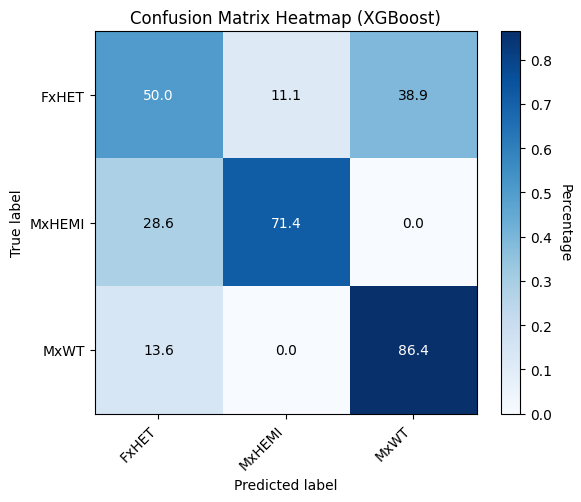

In [19]:
import matplotlib.pyplot as plt

# Plot confusion matrix heatmap
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Percentage", rotation=-90, va="bottom")

# Tick labels
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel="True label",
    xlabel="Predicted label",
    title=f"Confusion Matrix Heatmap ({best_name})"
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Write the % values inside the cells
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(
            j, i, f"{cm_norm[i, j]*100:.1f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


# Cross Validation of the best model

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
import numpy as np

# Convert to numpy for CV
X_np = X_model.astype(np.float32).values
y_np = y_enc.copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, f1ms = [], []

for tr, te in skf.split(X_np, y_np):
    xtr, xte = X_np[tr], X_np[te]
    ytr, yte = y_np[tr], y_np[te]

    # Sample weights (to handle class imbalance)
    sw = np.array([class_weight_map[c] for c in ytr], dtype=float)

    # Define XGBoost model
    xgb = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        n_estimators=700,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=2.0,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=0.5,
        random_state=42,
        tree_method="hist"
    )

    # Train on fold
    xgb.fit(xtr, ytr, sample_weight=sw)

    # Predict on validation fold
    yhat = xgb.predict(xte)

    # Collect metrics
    accs.append(accuracy_score(yte, yhat))
    f1ms.append(f1_score(yte, yhat, average="macro"))

print("XGBoost 5-fold CV — Acc: {:.3f}±{:.3f} | Macro-F1: {:.3f}±{:.3f}"
      .format(np.mean(accs), np.std(accs), np.mean(f1ms), np.std(f1ms)))


XGBoost 5-fold CV — Acc: 0.688±0.027 | Macro-F1: 0.638±0.035


In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import numpy as np

# Use the SAME data arrays for both models
X_np = X_model.values   # leave NaNs; MLP pipeline will impute
y_np = y_enc.copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs_xgb, f1s_xgb = [], []
accs_mlp, f1s_mlp = [], []

for tr, te in skf.split(X_np, y_np):
    xtr, xte = X_np[tr], X_np[te]
    ytr, yte = y_np[tr], y_np[te]

    # sample weights (same as you used before)
    sw = np.array([class_weight_map[c] for c in ytr], dtype=float)

    # ---- XGBoost (handles NaNs natively)
    xgb = XGBClassifier(
        objective="multi:softprob", eval_metric="mlogloss",
        n_estimators=700, learning_rate=0.05,
        max_depth=6, min_child_weight=2.0,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=0.5, random_state=42, tree_method="hist"
    )
    xgb.fit(xtr, ytr, sample_weight=sw)
    yhat_x = xgb.predict(xte)
    accs_xgb.append(accuracy_score(yte, yhat_x))
    f1s_xgb.append(f1_score(yte, yhat_x, average="macro"))

    # ---- MLP (needs imputation inside pipeline)
    mlp = Pipeline([
        ("impute", SimpleImputer(strategy="median")),    # train-only median
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", MLPClassifier(hidden_layer_sizes=(256,128), alpha=1e-4,
                              max_iter=700, random_state=42))
    ])
    mlp.fit(xtr, ytr)
    yhat_m = mlp.predict(xte)
    accs_mlp.append(accuracy_score(yte, yhat_m))
    f1s_mlp.append(f1_score(yte, yhat_m, average="macro"))

print("XGB  5-fold — Acc: {:.3f}±{:.3f} | Macro-F1: {:.3f}±{:.3f}"
      .format(np.mean(accs_xgb), np.std(accs_xgb), np.mean(f1s_xgb), np.std(f1s_xgb)))
print("MLP  5-fold — Acc: {:.3f}±{:.3f} | Macro-F1: {:.3f}±{:.3f}"
      .format(np.mean(accs_mlp), np.std(accs_mlp), np.mean(f1s_mlp), np.std(f1s_mlp)))

# Optional: simple paired comparison on Macro-F1 across the 5 folds
diff = np.array(f1s_xgb) - np.array(f1s_mlp)
print("Per-fold Macro-F1 diffs (XGB - MLP):", np.round(diff, 4),
      " | mean diff =", np.round(diff.mean(), 4))


XGB  5-fold — Acc: 0.688±0.027 | Macro-F1: 0.638±0.035
MLP  5-fold — Acc: 0.629±0.033 | Macro-F1: 0.604±0.052
Per-fold Macro-F1 diffs (XGB - MLP): [ 0.021  0.041  0.009  0.111 -0.01 ]  | mean diff = 0.0343


# Printing the second best model's results

In [22]:
# === Metrics for the Second-Best Model ===
import numpy as np
from sklearn.metrics import (
    f1_score, accuracy_score, confusion_matrix, classification_report, log_loss
)

# Sort models by F1_macro (descending)
sorted_models = sorted(reports.items(), key=lambda kv: kv[1]["f1_macro"], reverse=True)

# Pick the second-best
second_name, second_report = sorted_models[1]
second_model = models[second_name]
second_pred = second_report["y_pred"]

print(f"\n=== Evaluation for Second-Best Model: {second_name} ===")

# Core metrics
acc = accuracy_score(y_te, second_pred)
f1m = f1_score(y_te, second_pred, average="macro")
print(f"{second_name} — Acc: {acc:.3f} | F1_macro: {f1m:.3f}")

# Optional: probability-based metric (log loss)
if hasattr(second_model, "predict_proba"):
    y_proba = second_model.predict_proba(X_te.astype(np.float32))
    ll = log_loss(y_te, y_proba, labels=np.arange(len(le.classes_)))
    print(f"LogLoss: {ll:.4f}")

# Confusion matrix
labels = list(le.classes_)
cm = confusion_matrix(y_te, second_pred, labels=np.arange(len(labels)))
print("Label order:", labels)
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# Row-normalized (per-true-class recall breakdown)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
np.set_printoptions(precision=3, suppress=True)
print("Row-normalized (%):\n", np.round(100 * cm_norm, 1))

# Per-class precision/recall/F1
print(f"\nClassification report ({second_name}):\n")
print(classification_report(y_te, second_pred, target_names=labels, digits=3))



=== Evaluation for Second-Best Model: LightGBM ===
LightGBM — Acc: 0.660 | F1_macro: 0.649
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
LogLoss: 1.4244
Label order: ['FxHET', 'MxHEMI', 'MxWT']
Confusion matrix (rows=true, cols=pred):
 [[ 9  1  8]
 [ 3  4  0]
 [ 4  0 18]]
Row-normalized (%):
 [[50.   5.6 44.4]
 [42.9 57.1  0. ]
 [18.2  0.  81.8]]

Classification report (LightGBM):

              precision    recall  f1-score   support

       FxHET      0.562     0.500     0.529        18
      MxHEMI      0.800     0.571     0.667         7
        MxWT      0.692     

In [23]:
# Class distribution in the full labeled set
print(pd.Series(le.inverse_transform(y_enc)).value_counts())

# Majority-class baseline accuracy on the test set
maj = np.bincount(y_tr).argmax()
maj_acc = (y_te == maj).mean()
print(f"Majority-class baseline (test): {maj_acc:.3f}")


MxWT      86
FxHET     70
MxHEMI    30
Name: count, dtype: int64
Majority-class baseline (test): 0.468


# what does the above cell mean 

Your dataset contains three neuron types: MxWT (86 samples), FxHET (70 samples), and MxHEMI (30 samples). This shows the data is imbalanced, with MxWT being the largest group and MxHEMI the smallest. If you built a trivial model that always predicts the majority class (MxWT), it would achieve about 46.8% accuracy on the test set. This baseline highlights the minimum standard your models must beat—any model performing only slightly better than ~47% isn’t very useful, but models that score well above this baseline are genuinely learning meaningful patterns from the features.

Total = 86 + 70 + 30 = 186 samples overall → mild imbalance:

MxWT ≈ 46%

FxHET ≈ 38%

MxHEMI ≈ 16%

# SHAP Analysis

In [24]:
!pip install shap

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.5/555.5 kB 9.5 MB/s  0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 33.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 42.0 MB/s  0:00:00m0:00:0100:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [shap]6/7 [shap]]te]


# Summary Plot
The summary plot shows the feature importance of each feature in the model

In [25]:
print(list(X_model.columns))


['L', 'bursts_per_min', 'first_burst_time', 'last_burst_time', 'approx_recording_span_sec', 'has_bursts', 'Burst_Peak_List__mean', 'Burst_Peak_List__std', 'Burst_Peak_List__median', 'Burst_Peak_List__mad', 'Burst_Peak_List__min', 'Burst_Peak_List__q10', 'Burst_Peak_List__q25', 'Burst_Peak_List__q50', 'Burst_Peak_List__q75', 'Burst_Peak_List__q90', 'Burst_Peak_List__max', 'Burst_Peak_List__skew', 'Burst_Peak_List__kurtosis', 'Burst_Times_List__mean', 'Burst_Times_List__std', 'Burst_Times_List__median', 'Burst_Times_List__mad', 'Burst_Times_List__min', 'Burst_Times_List__q10', 'Burst_Times_List__q25', 'Burst_Times_List__q50', 'Burst_Times_List__q75', 'Burst_Times_List__q90', 'Burst_Times_List__max', 'Burst_Times_List__skew', 'Burst_Times_List__kurtosis', 'IBI_List__mean', 'IBI_List__std', 'IBI_List__median', 'IBI_List__mad', 'IBI_List__min', 'IBI_List__q10', 'IBI_List__q25', 'IBI_List__q50', 'IBI_List__q75', 'IBI_List__q90', 'IBI_List__max', 'IBI_List__skew', 'IBI_List__kurtosis', 'Spike

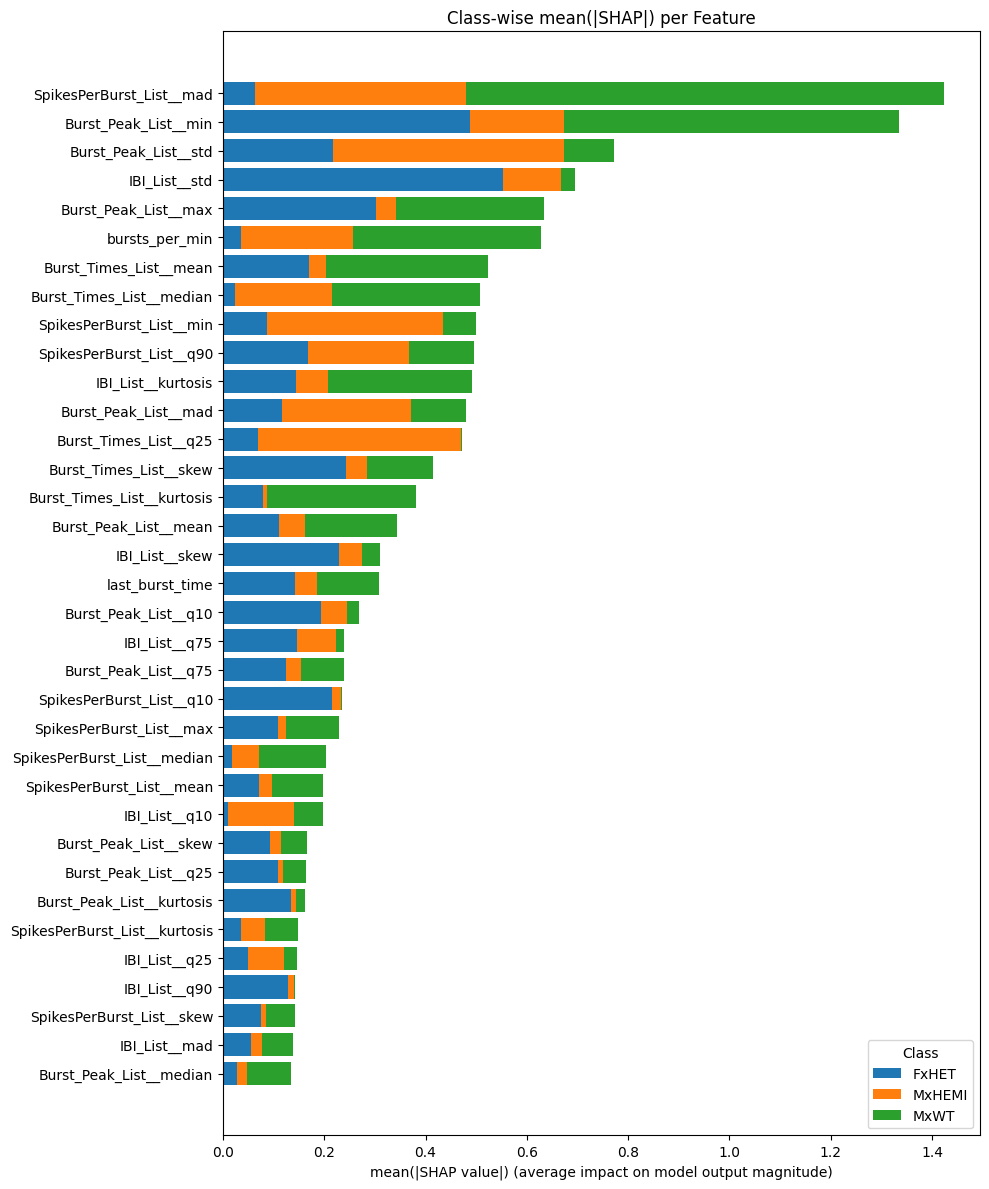

In [28]:
# --- Class-wise mean(|SHAP|) horizontal stacked bars (like your screenshot) ---

# If SHAP not installed yet:
# !pip install shap

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# ---- 1) Build explainer + pick eval subset (fast & reproducible) ----
feature_names = list(X_model.columns)

bg_n = min(1000, len(X_tr))
te_n = min(1000, len(X_te))
X_bg   = X_tr.sample(n=bg_n, random_state=42).astype(np.float32)
X_eval = X_te.sample(n=te_n, random_state=42).astype(np.float32)

# Modern wrapper first; fall back to TreeExplainer for older SHAP
try:
    explainer = shap.Explainer(xgb, X_bg, feature_names=feature_names)
    sv = explainer(X_eval)  # shap.Explanation
except Exception:
    explainer = shap.TreeExplainer(xgb)
    sv = explainer.shap_values(X_eval)  # list-of-arrays per class (old API)

# ---- 2) Compute mean(|SHAP|) per feature, per class (works for both APIs) ----
def classwise_mean_abs_shap(shap_values, feature_names, class_names=None):
    """
    Returns a DataFrame with columns: feature, Class 0, Class 1, ..., Total
    Compatible with:
      - list of arrays [n_classes x (n_samples, n_features)]
      - Explanation/ndarray with shape (n_samples, n_features, n_classes)
      - (rare) 2D array (n_samples, n_features) → treated as 1-class
    """
    if isinstance(shap_values, list):
        # Old API: list-of-arrays (one (n_samples, n_features) per class)
        per_class = [np.mean(np.abs(a), axis=0) for a in shap_values]
        mat = np.vstack(per_class)  # (n_classes, n_features)
    else:
        vals = shap_values.values if hasattr(shap_values, "values") else shap_values
        if vals.ndim == 3:
            # (n_samples, n_features, n_classes)
            mat = np.mean(np.abs(vals), axis=0).T  # -> (n_classes, n_features)
        elif vals.ndim == 2:
            # Single "class" case: (n_samples, n_features)
            mat = np.mean(np.abs(vals), axis=0, keepdims=True)  # (1, n_features)
        else:
            raise ValueError(f"Unexpected SHAP array shape: {vals.shape}")

    n_classes, n_features = mat.shape
    if class_names is None:
        class_names = [f"Class {i}" for i in range(n_classes)]
    col_names = list(class_names)

    df = pd.DataFrame(mat.T, columns=col_names)
    df.insert(0, "feature", feature_names)
    df["Total"] = df[col_names].sum(axis=1)
    return df.sort_values("Total", ascending=False).reset_index(drop=True)

class_names = list(getattr(le, "classes_", [f"Class {i}" for i in range(xgb.n_classes_) ]))
df_imp = classwise_mean_abs_shap(sv, feature_names, class_names)

# ---- 3) Plot top-K features as stacked horizontal bars ----
TOP_K = 35  # adjust as you like
plot_df = df_imp.head(TOP_K).iloc[::-1]  # reverse for top at top

fig, ax = plt.subplots(figsize=(10,12))
left = np.zeros(len(plot_df))
class_cols = [c for c in plot_df.columns if c not in ("feature", "Total")]

for c in class_cols:
    ax.barh(plot_df["feature"], plot_df[c].values, left=left, label=c)
    left += plot_df[c].values

ax.set_xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
ax.legend(title="Class", loc="lower right")
ax.set_title("Class-wise mean(|SHAP|) per Feature")
plt.tight_layout()
plt.show()


# Summary plot of the label '0'
- Y-axis indicates the feature names in order of importance from top to bottom.
- X-axis represents the SHAP value, which indicates the degree of change in log odds.
- The color of each point on the graph represents the value of the corresponding feature, with red indicating high values and blue indicating low values.
- Each point represents a row of data from the original dataset.

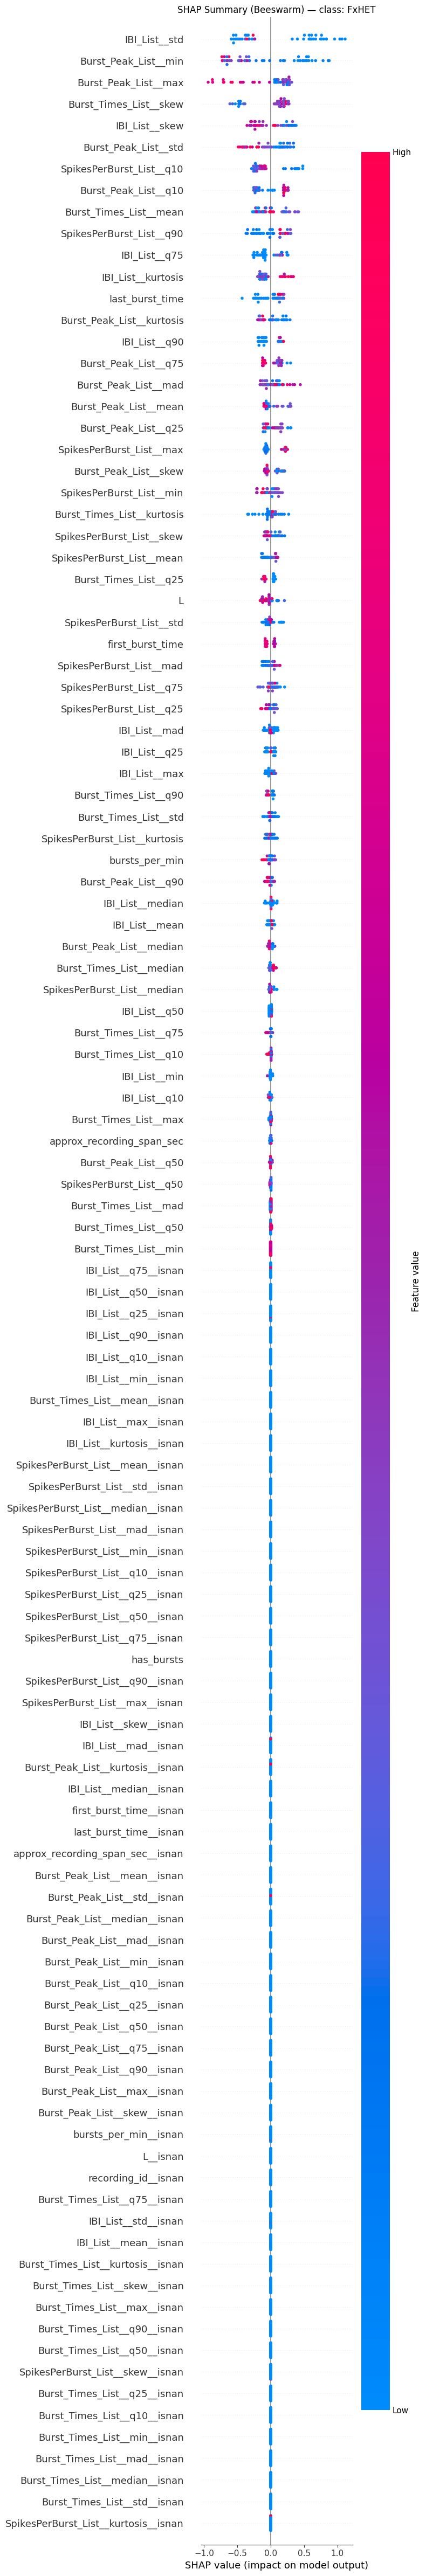

Saved: shap_beeswarm_FxHET.png


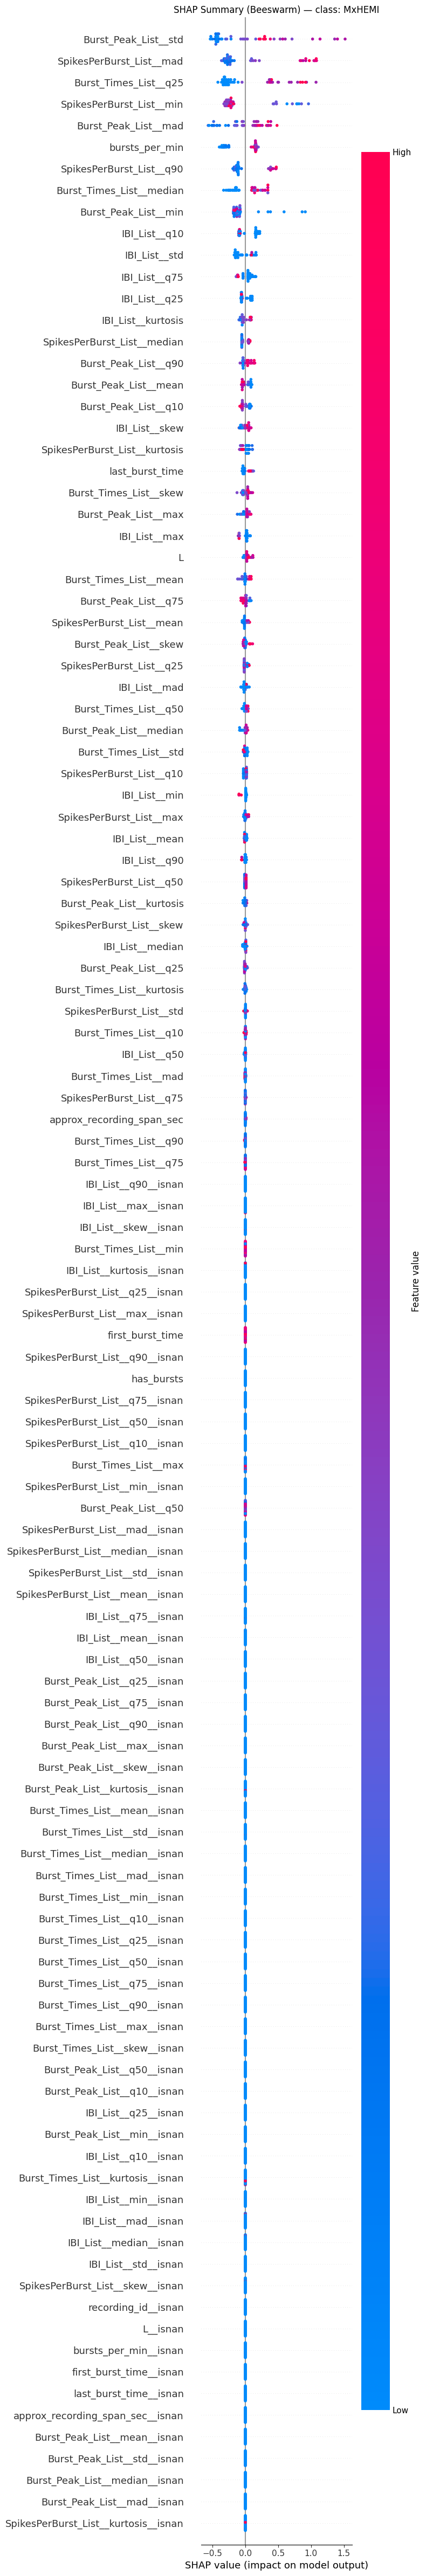

Saved: shap_beeswarm_MxHEMI.png


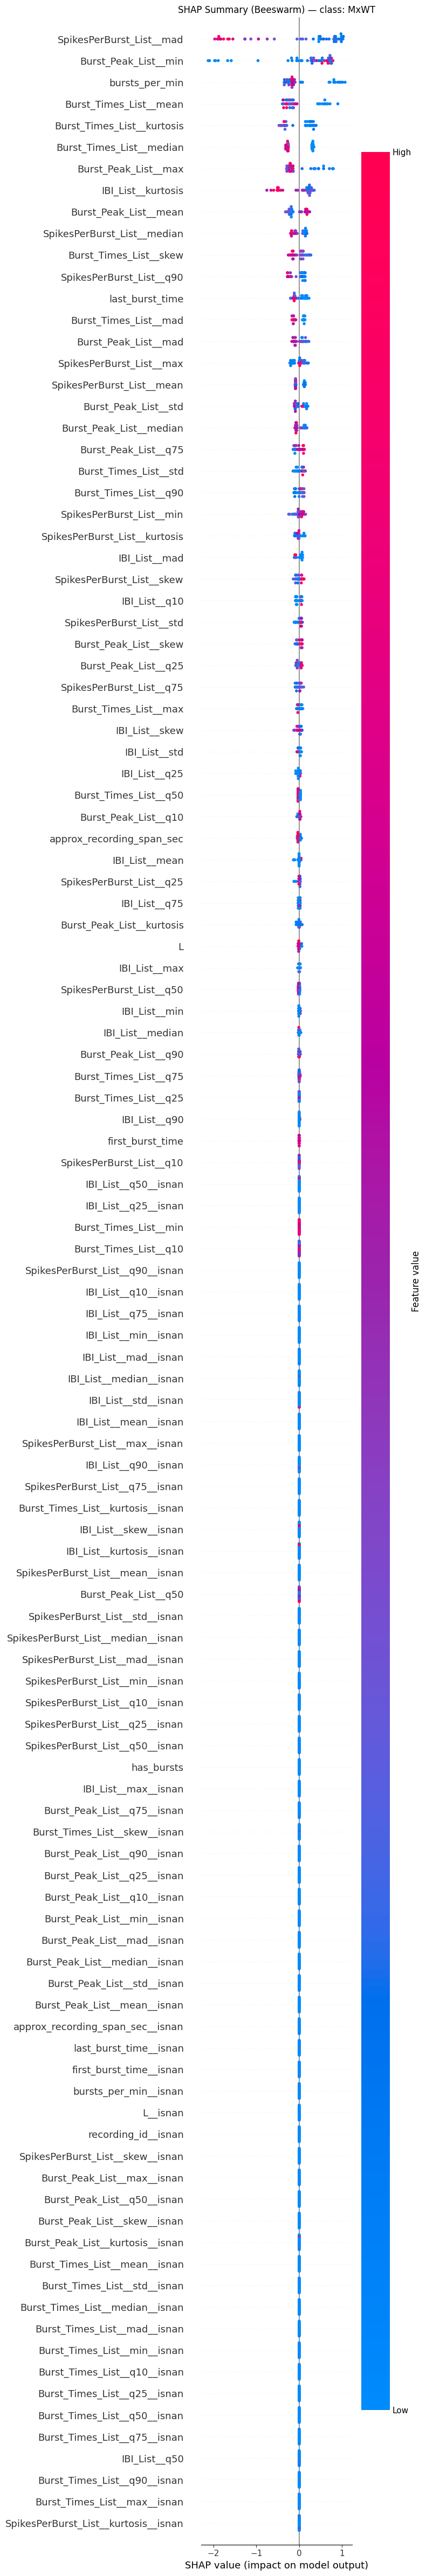

Saved: shap_beeswarm_MxWT.png


In [29]:
# Beeswarm for ALL classes (one plot per class), and also save PNGs

import numpy as np
import matplotlib.pyplot as plt
import shap

feature_names = list(X_model.columns)

# Use your existing eval/background or create them if missing
if "X_eval" not in globals():
    X_bg   = X_tr.sample(min(1000, len(X_tr)), random_state=42).astype(np.float32)
    X_eval = X_te.astype(np.float32)

# Build explainer / SHAP values if not already available as `sv`
if "sv" not in globals():
    try:
        explainer = shap.Explainer(xgb, X_bg, feature_names=feature_names)
        sv = explainer(X_eval)   # shap.Explanation
    except Exception:
        explainer = shap.TreeExplainer(xgb)
        sv = explainer.shap_values(X_eval)  # list per class (old API)

# Get class names (from your LabelEncoder)
class_names = list(le.classes_)

def get_sv_for_class(sv_obj, class_idx):
    """Return a 2D array (n_samples, n_features) for the given class index,
       handling both new and old SHAP APIs."""
    if isinstance(sv_obj, list):        # old API: list of arrays per class
        return sv_obj[class_idx]
    vals = sv_obj.values if hasattr(sv_obj, "values") else sv_obj
    if vals.ndim == 3:                  # (n_samples, n_features, n_classes)
        return vals[:, :, class_idx]
    return vals                         # already 2D (binary-collapsed)

# Loop over classes and plot
for ci, cname in enumerate(class_names):
    sv_class = get_sv_for_class(sv, ci)
    plt.figure(figsize=(9, max(6, len(feature_names)*0.35)))
    shap.summary_plot(
        sv_class,
        X_eval,
        feature_names=feature_names,
        show=False,
        max_display=len(feature_names)  # show ALL features
    )
    plt.title(f"SHAP Summary (Beeswarm) — class: {cname}")
    plt.tight_layout()
    # Save and show
    out_path = f"shap_beeswarm_{cname}.png"
    plt.savefig(out_path, dpi=180, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")


In [24]:
# ---- Compact per-class direction summary (sign + strength) ----
import numpy as np, pandas as pd, shap
from scipy.stats import spearmanr

feature_names = list(X_model.columns)

# Ensure eval/background + SHAP values exist
if "X_eval" not in globals():
    X_bg   = X_tr.sample(min(1000, len(X_tr)), random_state=42).astype(np.float32)
    X_eval = X_te.astype(np.float32)

if "explainer" not in globals() or "sv" not in globals():
    try:
        explainer = shap.Explainer(xgb, X_bg, feature_names=feature_names)
        sv = explainer(X_eval)                  # new API: Explanation
    except Exception:
        explainer = shap.TreeExplainer(xgb)
        sv = explainer.shap_values(X_eval)      # old API: list per class

def _sv_matrix_for_class(sv_obj, ci):
    if isinstance(sv_obj, list):
        return sv_obj[ci]                       # (n_samples, n_features)
    vals = sv_obj.values if hasattr(sv_obj, "values") else sv_obj
    return vals[:, :, ci] if vals.ndim == 3 else vals

def _mean_abs_shap_per_feat(mat):               # mat: (n_samples, n_features)
    return np.mean(np.abs(mat), axis=0)

classes = list(le.classes_)
for ci, cname in enumerate(classes):
    shap_mat = _sv_matrix_for_class(sv, ci)             # (n_samples, n_features)
    mas = _mean_abs_shap_per_feat(shap_mat)

    rows = []
    for j, feat in enumerate(feature_names):
        rho, _ = spearmanr(np.asarray(X_eval[feat]), shap_mat[:, j])
        rows.append((feat, mas[j], rho))
    df = pd.DataFrame(rows, columns=["feature", "mean_abs_shap", "spearman_value_vs_shap"])
    df.sort_values("mean_abs_shap", ascending=False, inplace=True)

    # Keep a compact view
    top = df.head(25)
    top["direction"] = np.where(top["spearman_value_vs_shap"] > 0, "higher → toward class", "higher → away from class")
    display(top[["feature", "mean_abs_shap", "spearman_value_vs_shap", "direction"]])

    out = f"shap_direction_summary_{cname}.csv"
    top.to_csv(out, index=False)
    print("Saved:", out)


/var/folders/kx/v7vqz39d5nn79sxpbgh1vn3w0000gn/T/ipykernel_2079/1722524870.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(np.asarray(X_eval[feat]), shap_mat[:, j])
/var/folders/kx/v7vqz39d5nn79sxpbgh1vn3w0000gn/T/ipykernel_2079/1722524870.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top["direction"] = np.where(top["spearman_value_vs_shap"] > 0, "higher → toward class", "higher → away from class")


feature  mean_abs_shap  spearman_value_vs_shap  \
33               IBI_List__std       0.594517               -0.662234   
10        Burst_Peak_List__min       0.483316               -0.870722   
16        Burst_Peak_List__max       0.283776               -0.466004   
43              IBI_List__skew       0.234033               -0.686250   
30      Burst_Times_List__skew       0.230352                0.660846   
7         Burst_Peak_List__std       0.228489               -0.738668   
50    SpikesPerBurst_List__q10       0.227093               -0.106270   
11        Burst_Peak_List__q10       0.186284                0.561170   
19      Burst_Times_List__mean       0.176884                0.362753   
54    SpikesPerBurst_List__q90       0.164520                0.661772   
3              last_burst_time       0.160342                0.856384   
40               IBI_List__q75       0.148122                0.362054   
41               IBI_List__q90       0.138236                0.429678   
14        Burst_Peak_List__q75       0.131193               -0.851295   
44          IBI_List__kurtosis       0.130356                0.508963   
18   Burst_Peak_List__kurtosis       0.127932               -0.800046   
12        Burst_Peak_List__q25       0.111881               -0.322734   
9         Burst_Peak_List__mad       0.108847                0.049144   
6        Burst_Peak_List__mean       0.103433                0.078515   
55    SpikesPerBurst_List__max       0.096004                0.708372   
49    SpikesPerBurst_List__min       0.088433               -0.529439   
31  Burst_Times_List__kurtosis       0.077402                0.429744   
45   SpikesPerBurst_List__mean       0.076167                0.736702   
46    SpikesPerBurst_List__std       0.076054               -0.010407   
17       Burst_Peak_List__skew       0.073344               -0.543363   

                   direction  
33  higher → away from class  
10  higher → away from class  
16  higher → away from class  
43  higher → away from class  
30     higher → toward class  
7   higher → away from class  
50  higher → away from class  
11     higher → toward class  
19     higher → toward class  
54     higher → toward class  
3      higher → toward class  
40     higher → toward class  
41     higher → toward class  
14  higher → away from class  
44     higher → toward class  
18  higher → away from class  
12  higher → away from class  
9      higher → toward class  
6      higher → toward class  
55     higher → toward class  
49  higher → away from class  
31     higher → toward class  
45     higher → toward class  
46  higher → away from class  
17  higher → away from class

Saved: shap_direction_summary_FxHET.csv


/var/folders/kx/v7vqz39d5nn79sxpbgh1vn3w0000gn/T/ipykernel_2079/1722524870.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(np.asarray(X_eval[feat]), shap_mat[:, j])
/var/folders/kx/v7vqz39d5nn79sxpbgh1vn3w0000gn/T/ipykernel_2079/1722524870.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top["direction"] = np.where(top["spearman_value_vs_shap"] > 0, "higher → toward class", "higher → away from class")


feature  mean_abs_shap  spearman_value_vs_shap  \
7            Burst_Peak_List__std       0.445037                0.815333   
48       SpikesPerBurst_List__mad       0.419642                0.647972   
25          Burst_Times_List__q25       0.391617                0.838589   
49       SpikesPerBurst_List__min       0.354786               -0.294101   
9            Burst_Peak_List__mad       0.244103                0.933626   
1                  bursts_per_min       0.236812                0.699162   
54       SpikesPerBurst_List__q90       0.202006                0.317068   
21       Burst_Times_List__median       0.196937                0.753941   
10           Burst_Peak_List__min       0.181378               -0.274052   
37                  IBI_List__q10       0.123115               -0.740044   
33                  IBI_List__std       0.117895                0.841722   
40                  IBI_List__q75       0.082084               -0.413606   
38                  IBI_List__q25       0.066207               -0.735542   
11           Burst_Peak_List__q10       0.060335               -0.937289   
44             IBI_List__kurtosis       0.059262                0.793974   
6           Burst_Peak_List__mean       0.058626               -0.789303   
47    SpikesPerBurst_List__median       0.051305                0.887573   
15           Burst_Peak_List__q90       0.050954                0.843380   
57  SpikesPerBurst_List__kurtosis       0.050534               -0.542863   
16           Burst_Peak_List__max       0.049887                0.811367   
3                 last_burst_time       0.047065                0.814308   
43                 IBI_List__skew       0.043937                0.690413   
0                               L       0.042471                0.629601   
42                  IBI_List__max       0.039781               -0.247354   
30         Burst_Times_List__skew       0.035547                0.752530   

                   direction  
7      higher → toward class  
48     higher → toward class  
25     higher → toward class  
49  higher → away from class  
9      higher → toward class  
1      higher → toward class  
54     higher → toward class  
21     higher → toward class  
10  higher → away from class  
37  higher → away from class  
33     higher → toward class  
40  higher → away from class  
38  higher → away from class  
11  higher → away from class  
44     higher → toward class  
6   higher → away from class  
47     higher → toward class  
15     higher → toward class  
57  higher → away from class  
16     higher → toward class  
3      higher → toward class  
43     higher → toward class  
0      higher → toward class  
42  higher → away from class  
30     higher → toward class

Saved: shap_direction_summary_MxHEMI.csv


/var/folders/kx/v7vqz39d5nn79sxpbgh1vn3w0000gn/T/ipykernel_2079/1722524870.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = spearmanr(np.asarray(X_eval[feat]), shap_mat[:, j])
/var/folders/kx/v7vqz39d5nn79sxpbgh1vn3w0000gn/T/ipykernel_2079/1722524870.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top["direction"] = np.where(top["spearman_value_vs_shap"] > 0, "higher → toward class", "higher → away from class")


feature  mean_abs_shap  spearman_value_vs_shap  \
48       SpikesPerBurst_List__mad       0.971212               -0.812234   
10           Burst_Peak_List__min       0.679932                0.783071   
1                  bursts_per_min       0.355304               -0.444971   
19         Burst_Times_List__mean       0.334287               -0.507242   
16           Burst_Peak_List__max       0.304286               -0.489130   
31     Burst_Times_List__kurtosis       0.293243               -0.613970   
44             IBI_List__kurtosis       0.291798               -0.540419   
21       Burst_Times_List__median       0.274539               -0.842927   
6           Burst_Peak_List__mean       0.167201                0.674376   
54       SpikesPerBurst_List__q90       0.132677               -0.627660   
3                 last_burst_time       0.131422               -0.772949   
47    SpikesPerBurst_List__median       0.124900               -0.840541   
55       SpikesPerBurst_List__max       0.124211                0.624671   
9            Burst_Peak_List__mad       0.112950               -0.869103   
30         Burst_Times_List__skew       0.108774               -0.905527   
7            Burst_Peak_List__std       0.105864               -0.367484   
22          Burst_Times_List__mad       0.104529               -0.844320   
45      SpikesPerBurst_List__mean       0.098761               -0.825754   
14           Burst_Peak_List__q75       0.086404                0.914284   
8         Burst_Peak_List__median       0.082763               -0.723273   
20          Burst_Times_List__std       0.077726                0.828713   
28          Burst_Times_List__q90       0.075365                0.543697   
49       SpikesPerBurst_List__min       0.067877                0.621284   
57  SpikesPerBurst_List__kurtosis       0.066443               -0.355856   
12           Burst_Peak_List__q25       0.061392                0.720613   

                   direction  
48  higher → away from class  
10     higher → toward class  
1   higher → away from class  
19  higher → away from class  
16  higher → away from class  
31  higher → away from class  
44  higher → away from class  
21  higher → away from class  
6      higher → toward class  
54  higher → away from class  
3   higher → away from class  
47  higher → away from class  
55     higher → toward class  
9   higher → away from class  
30  higher → away from class  
7   higher → away from class  
22  higher → away from class  
45  higher → away from class  
14     higher → toward class  
8   higher → away from class  
20     higher → toward class  
28     higher → toward class  
49     higher → toward class  
57  higher → away from class  
12     higher → toward class

Saved: shap_direction_summary_MxWT.csv


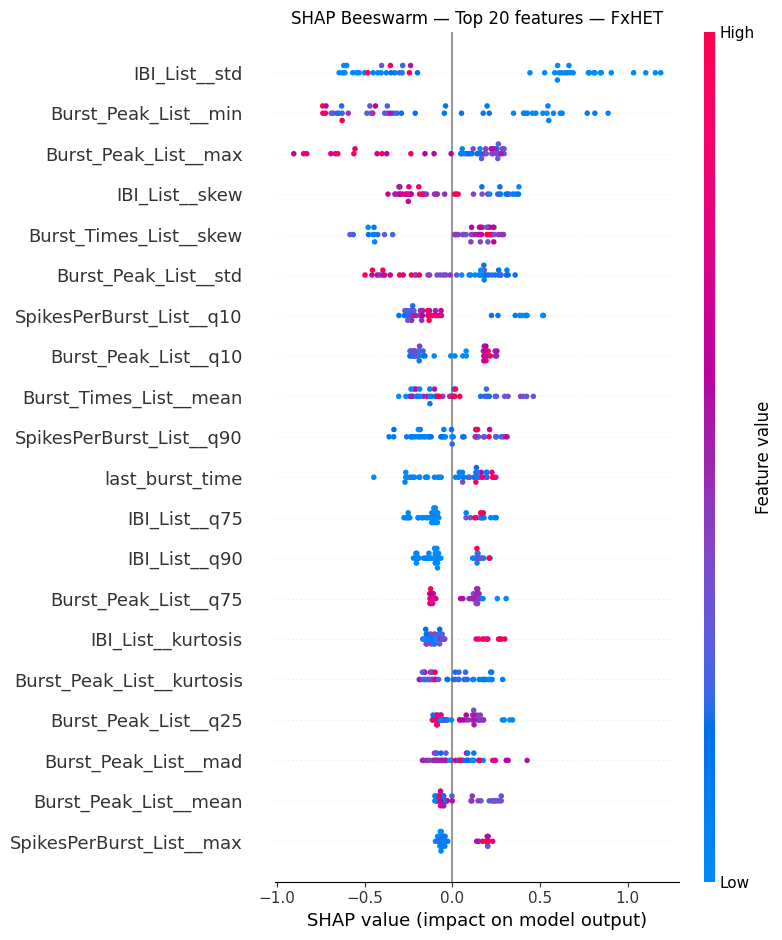

Saved: shap_beeswarm_top20_FxHET.png


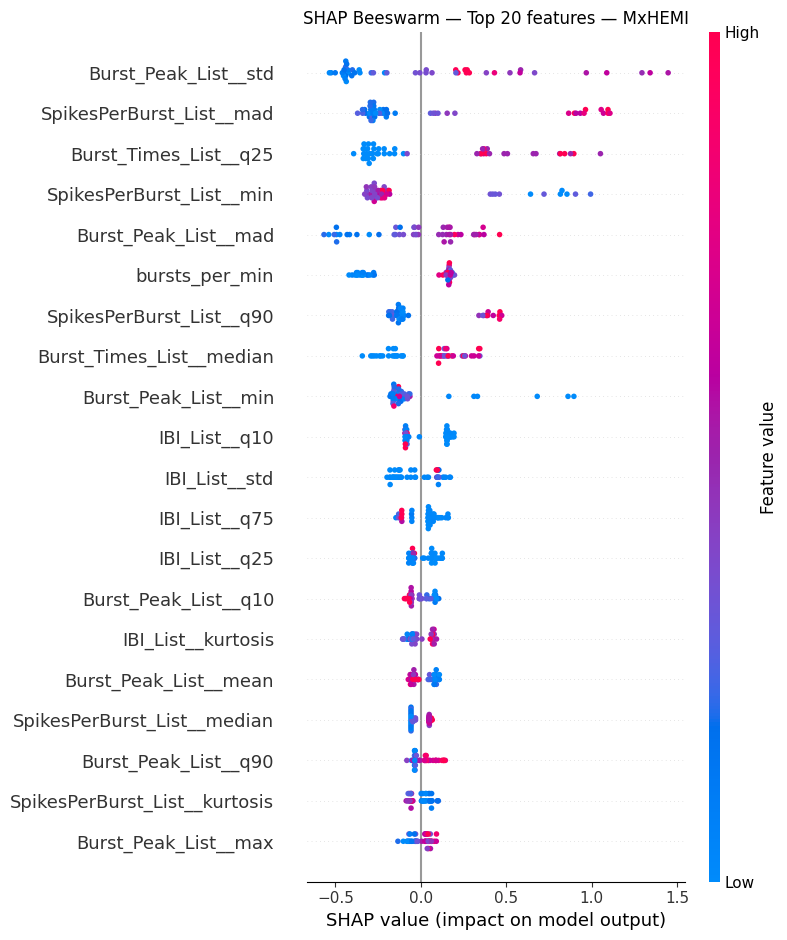

Saved: shap_beeswarm_top20_MxHEMI.png


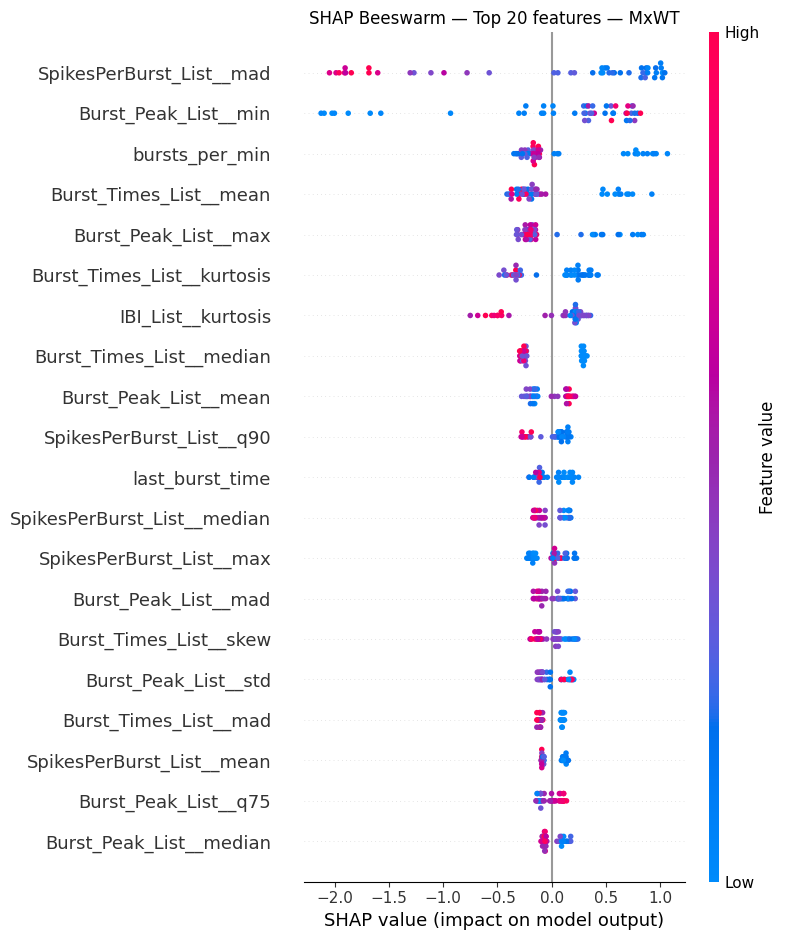

Saved: shap_beeswarm_top20_MxWT.png


In [41]:
# --- Beeswarm for TOP-K features per class (compact) ---
import numpy as np, matplotlib.pyplot as plt, shap

TOP_K = 20  # change as you like

feature_names = list(X_model.columns)

# Ensure eval/background + SHAP values exist
if "X_eval" not in globals():
    X_bg   = X_tr.sample(min(1000, len(X_tr)), random_state=42).astype(np.float32)
    X_eval = X_te.astype(np.float32)

if "explainer" not in globals() or "sv" not in globals():
    try:
        explainer = shap.Explainer(xgb, X_bg, feature_names=feature_names)
        sv = explainer(X_eval)                  # new API
    except Exception:
        explainer = shap.TreeExplainer(xgb)
        sv = explainer.shap_values(X_eval)      # old API: list per class

classes = list(le.classes_)

def _sv_class(sv_obj, ci):
    # Return (n_samples, n_features) for class ci
    if isinstance(sv_obj, list):        # old API
        return sv_obj[ci]
    vals = sv_obj.values if hasattr(sv_obj, "values") else sv_obj
    return vals[:, :, ci] if vals.ndim == 3 else vals

for ci, cname in enumerate(classes):
    sv_c = _sv_class(sv, ci)                         # (n_samples, n_features)
    mas  = np.mean(np.abs(sv_c), axis=0)             # mean |SHAP| per feature
    top_idx = np.argsort(-mas)[:TOP_K]               # indices of top-K
    fnames = [feature_names[i] for i in top_idx]

    plt.figure(figsize=(9, max(6, TOP_K * 0.35)))
    shap.summary_plot(
        sv_c[:, top_idx],
        X_eval.iloc[:, top_idx],
        feature_names=fnames,
        show=False,
        max_display=TOP_K
    )
    plt.title(f"SHAP Beeswarm — Top {TOP_K} features — {cname}")
    plt.tight_layout()
    out = f"shap_beeswarm_top{TOP_K}_{cname}.png"
    plt.savefig(out, dpi=180, bbox_inches="tight")
    plt.show()
    print("Saved:", out)


# Waterfall Plot
Shows how each feature contributes to the difference between the model's base value and the output prediction for a specific instance.

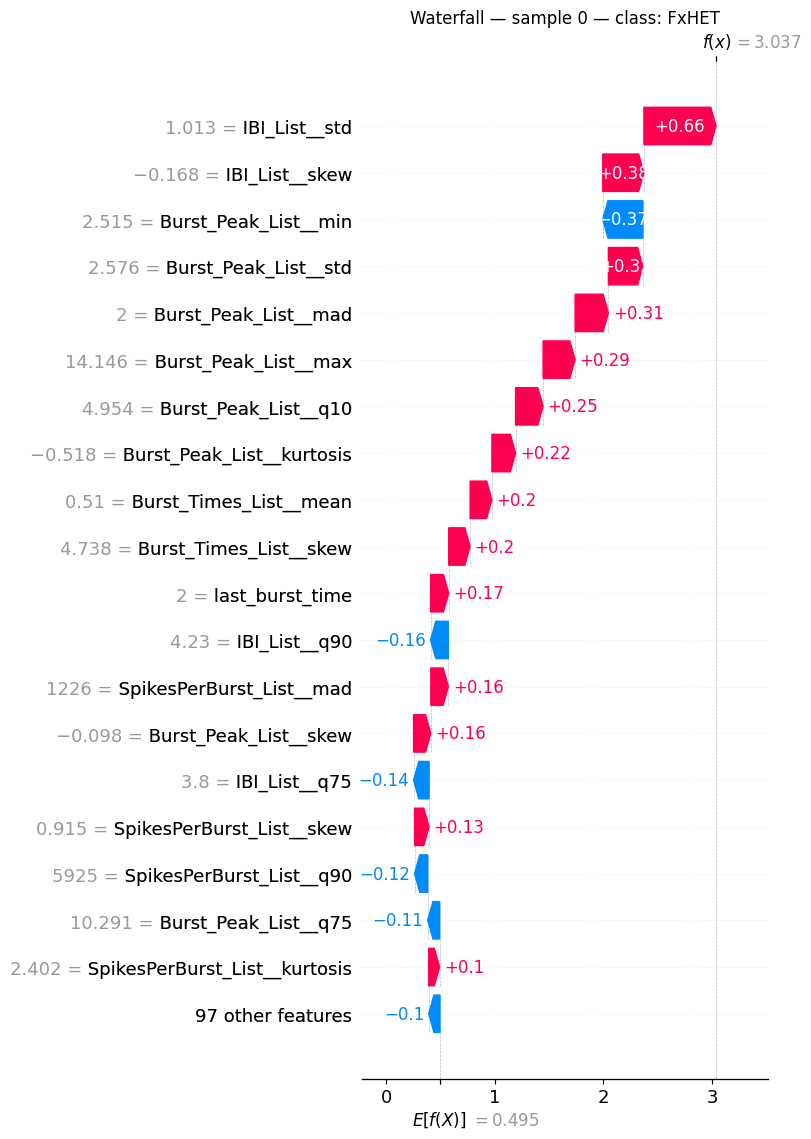

Saved: waterfall_sample0_FxHET.png


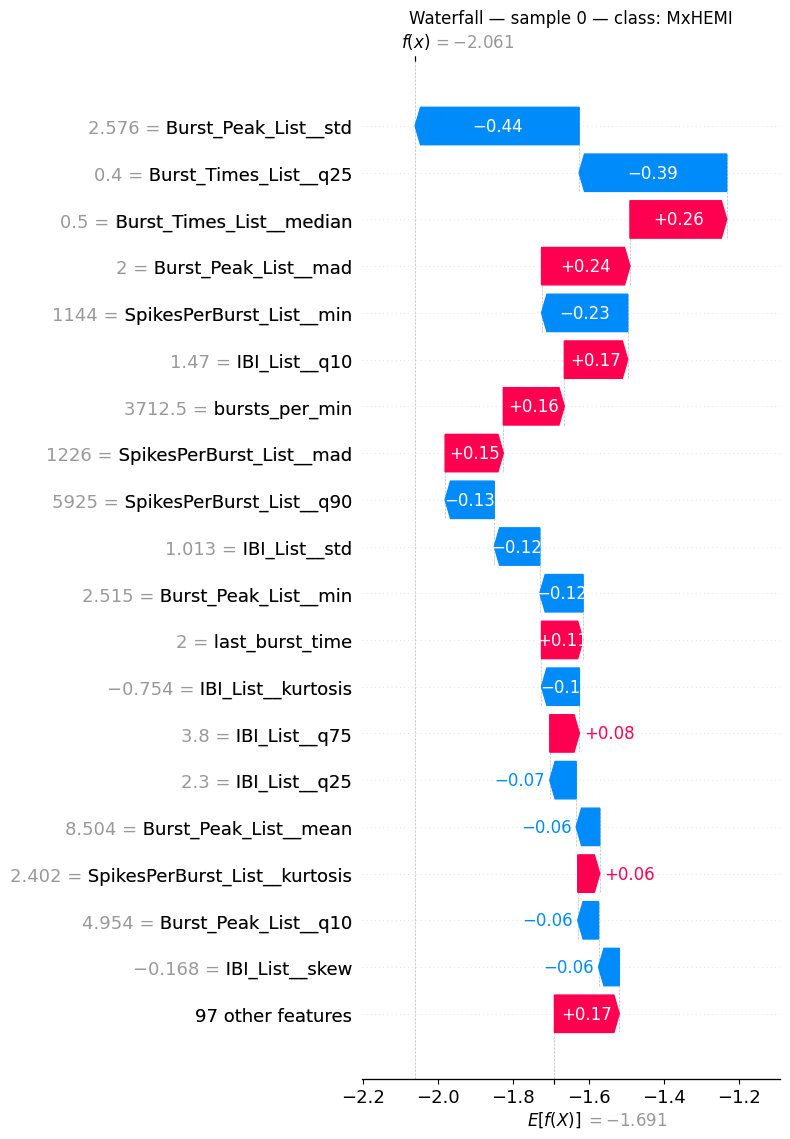

Saved: waterfall_sample0_MxHEMI.png


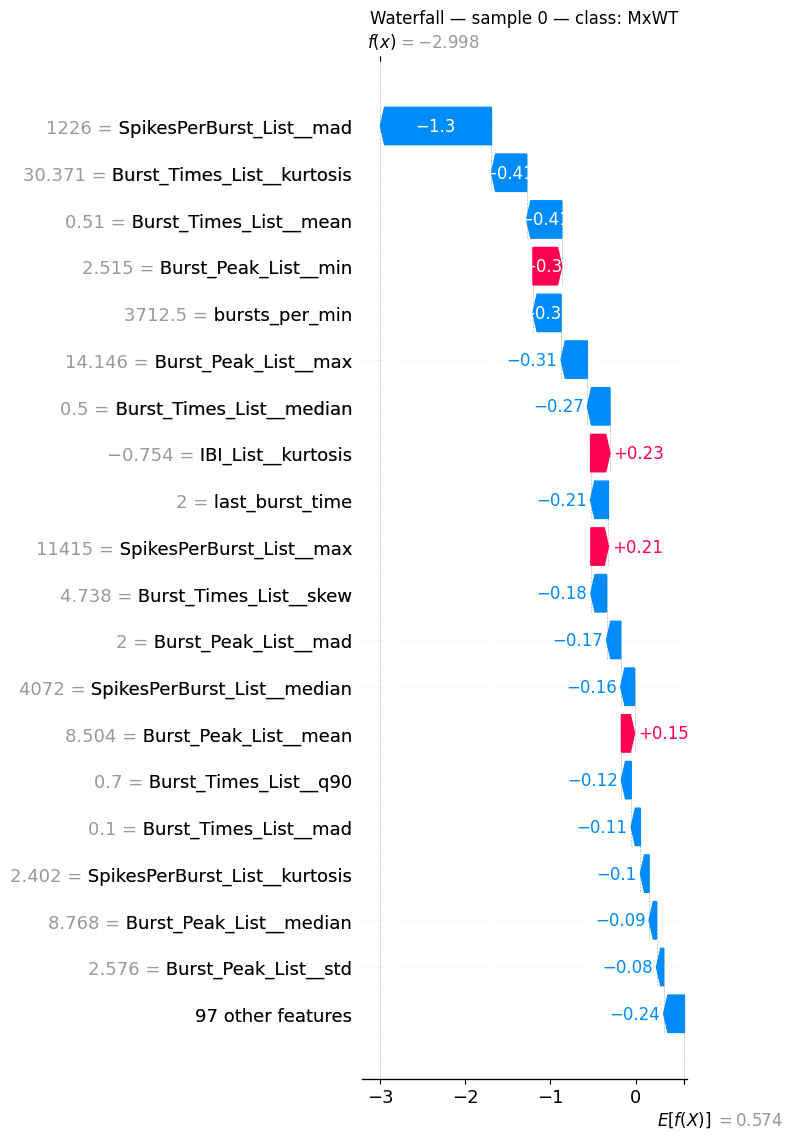

Saved: waterfall_sample0_MxWT.png


In [23]:
# --- SHAP Waterfall for ALL classes (compact) ---
import numpy as np, matplotlib.pyplot as plt, shap

FEATURES = list(X_model.columns)
IDX = 0                 # use the same test row for all classes
MOST_CONFIDENT = False  # set True to pick most-confident row per class
MAX_DISPLAY = 20

# Ensure eval/background + SHAP values exist
if "X_eval" not in globals():
    X_bg   = X_tr.sample(min(1000, len(X_tr)), random_state=42).astype(np.float32)
    X_eval = X_te.astype(np.float32)

if "explainer" not in globals() or "sv" not in globals():
    try:
        explainer = shap.Explainer(xgb, X_bg, feature_names=FEATURES)
        sv = explainer(X_eval)                 # new API: Explanation
    except Exception:
        explainer = shap.TreeExplainer(xgb)
        sv = explainer.shap_values(X_eval)     # old API: list per class

classes = list(le.classes_)
proba = xgb.predict_proba(X_eval)  # (n_samples, n_classes)

def explanation_for(idx, ci):
    x_row = X_eval.iloc[idx].values
    if isinstance(sv, list):  # old API
        vals = sv[ci][idx, :]
        base = explainer.expected_value
        base = float(base[ci] if hasattr(base, "__len__") else base)
        return shap.Explanation(values=vals, base_values=base, data=x_row, feature_names=FEATURES)
    vals  = sv.values
    basev = getattr(sv, "base_values", None)
    if vals.ndim == 3:  # (n, f, C)
        return shap.Explanation(values=vals[idx, :, ci],
                                base_values=float(basev[idx, ci]) if basev is not None else 0.0,
                                data=x_row, feature_names=FEATURES)
    return shap.Explanation(values=vals[idx, :],
                            base_values=float(basev[idx]) if basev is not None else 0.0,
                            data=x_row, feature_names=FEATURES)

for ci, cname in enumerate(classes):
    use_idx = int(np.argmax(proba[:, ci])) if MOST_CONFIDENT else IDX
    ex = explanation_for(use_idx, ci)
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(ex, max_display=MAX_DISPLAY, show=False)
    plt.title(f"Waterfall — sample {use_idx} — class: {cname}")
    plt.tight_layout()
    out = f"waterfall_sample{use_idx}_{cname}.png"
    plt.savefig(out, dpi=180, bbox_inches="tight")
    plt.show()
    print("Saved:", out)


In [48]:
# For sample i and class ci, check that base + sum(SHAP) ~ model logit
i, ci = 0, 0  # sample 0, class index 0 (e.g., FxHET)
proba = xgb.predict_proba(X_eval)
# Recover logits from probs via log-softmax inverse (relative to an arbitrary offset)
# Easier: directly compute base+sum(shap) from your Explanation:
ex = shap.Explanation(values=sv.values[i,:,ci], base_values=sv.base_values[i,ci], 
                      data=X_eval.iloc[i].values, feature_names=list(X_model.columns))
approx_logit = ex.base_values + ex.values.sum()
approx_logit


np.float64(3.036602859047618)

## To see which features you can add to make one neuron go from HET classification to WT classification

In [26]:
# assumes `sv` is the new Explanation with sv.values shaped (n, f, C) and
# `classes` has the class order; fallback: adapt if you're on the old API.
import numpy as np, pandas as pd

ci_wt  = classes.index("MxWT")     # adjust to your exact WT label
ci_het = classes.index("FxHET")    # adjust to your exact HET label

vals = sv.values                  # (n, f, C)
sh_wt  = vals[:, :, ci_wt]
sh_het = vals[:, :, ci_het]

df = pd.DataFrame({
    "feature": FEATURES,
    "mean_SHAP_WT": sh_wt.mean(0),
    "mean_abs_SHAP_WT": np.abs(sh_wt).mean(0),
    "mean_SHAP_HET": sh_het.mean(0),
    "mean_abs_SHAP_HET": np.abs(sh_het).mean(0),
    "mean_SHAP_HET_minus_WT": sh_het.mean(0) - sh_wt.mean(0)
}).sort_values("mean_SHAP_HET_minus_WT", ascending=False)

# Top drivers toward HET vs WT:
top_to_HET = df.head(20)
top_to_WT  = df.tail(20).iloc[::-1]
print("Toward HET:\n", top_to_HET[["feature","mean_SHAP_HET_minus_WT"]])
print("Toward WT:\n",  top_to_WT[["feature","mean_SHAP_HET_minus_WT"]])


Toward HET:
                         feature  mean_SHAP_HET_minus_WT
33                IBI_List__std                0.144426
48     SpikesPerBurst_List__mad                0.067444
6         Burst_Peak_List__mean                0.058436
14         Burst_Peak_List__q75                0.053375
12         Burst_Peak_List__q25                0.052573
19       Burst_Times_List__mean                0.031780
21     Burst_Times_List__median                0.031199
55     SpikesPerBurst_List__max                0.025316
53     SpikesPerBurst_List__q75                0.024083
9          Burst_Peak_List__mad                0.021607
56    SpikesPerBurst_List__skew                0.018021
17        Burst_Peak_List__skew                0.017567
22        Burst_Times_List__mad                0.012998
47  SpikesPerBurst_List__median                0.011989
3               last_burst_time                0.010298
30       Burst_Times_List__skew                0.009802
37                IBI_List__q10    

# Force Plot
We will examine the first sample in the testing set to determine which features contributed to the "0" result. To do this, we will utilize a force plot and provide the expected value, SHAP value, and testing sample.

### Most confident sample

In [37]:
proba = xgb.predict_proba(X_eval)  # (n_samples, n_classes)
class_names = list(le.classes_)

most_confident_idx = {class_names[ci]: int(np.argmax(proba[:, ci]))
                      for ci in range(proba.shape[1])}
most_confident_idx


{'FxHET': 0, 'MxHEMI': 6, 'MxWT': 44}

<Figure size 1200x260 with 0 Axes>

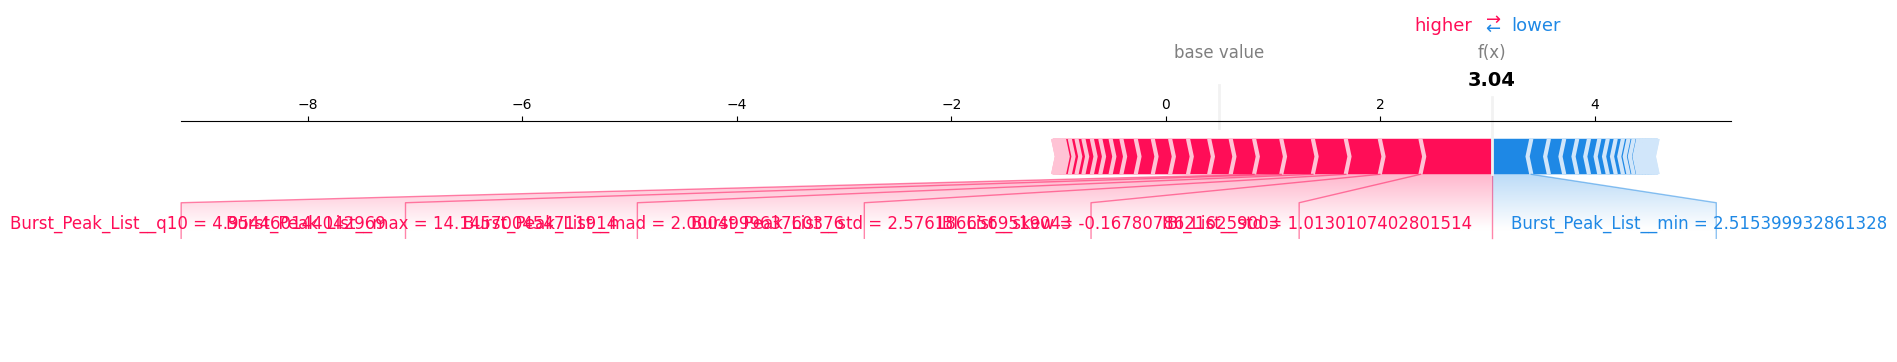

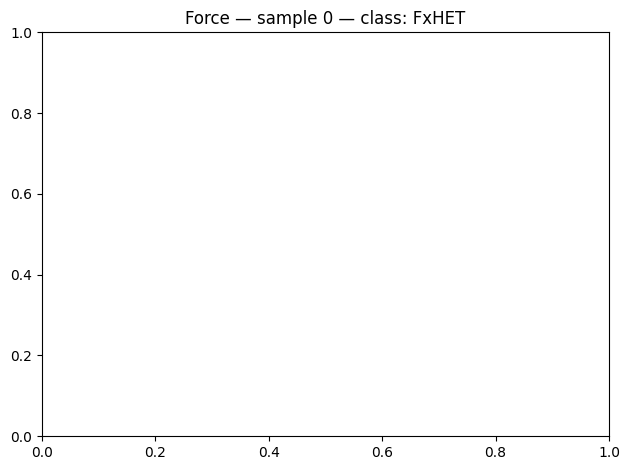

Saved HTML: force_sample0_FxHET.html
Saved PNG : force_sample0_FxHET.png


<Figure size 1200x260 with 0 Axes>

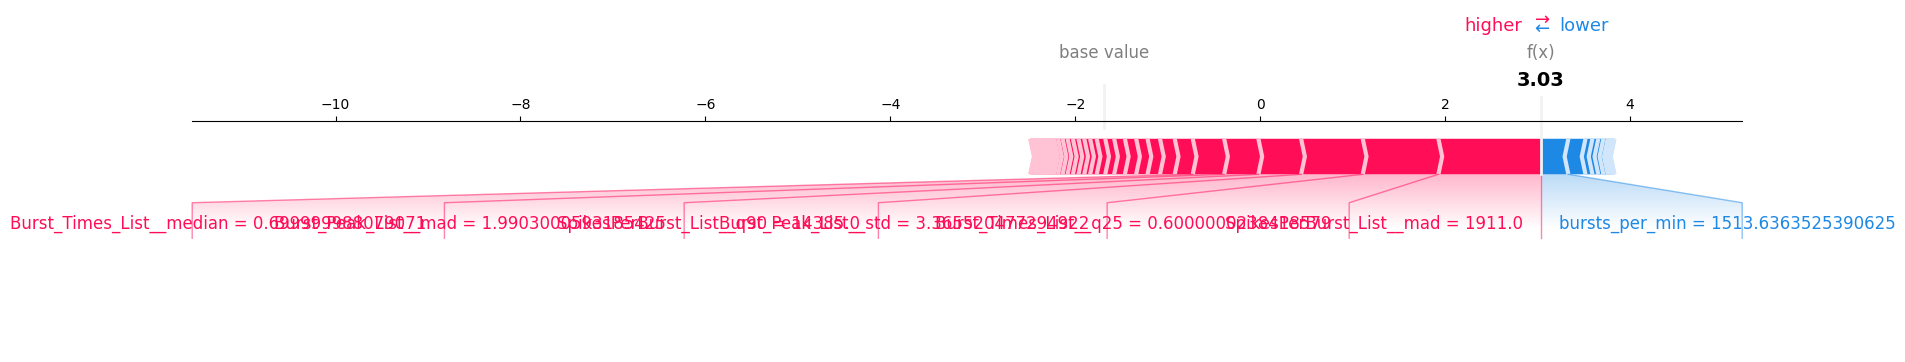

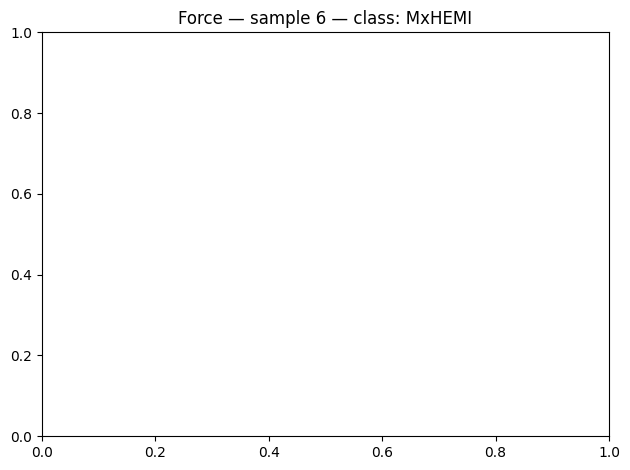

Saved HTML: force_sample6_MxHEMI.html
Saved PNG : force_sample6_MxHEMI.png


<Figure size 1200x260 with 0 Axes>

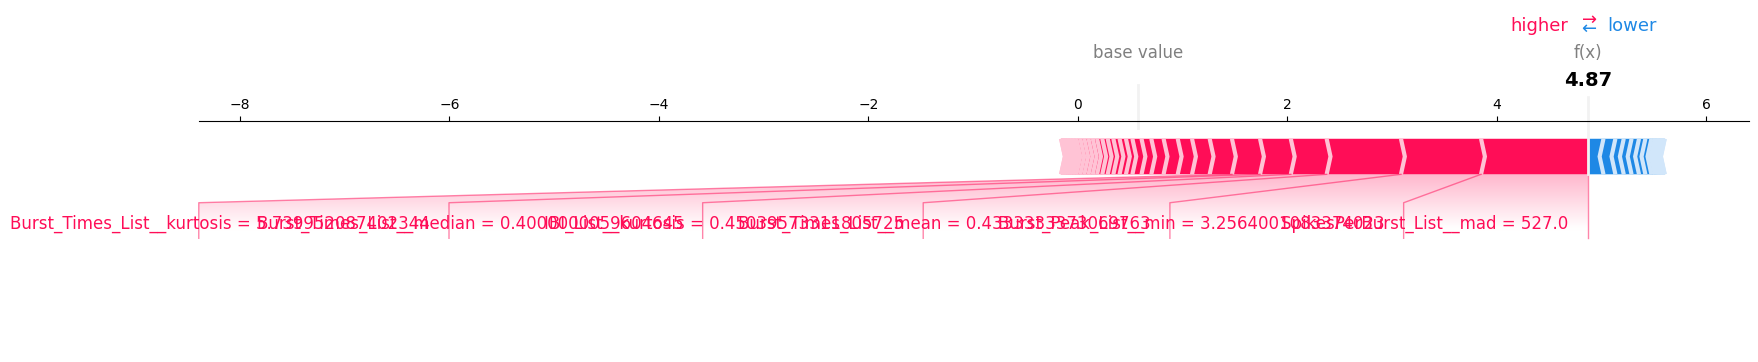

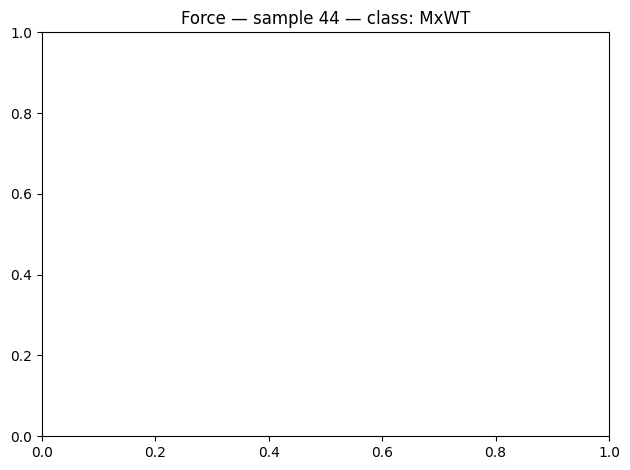

Saved HTML: force_sample44_MxWT.html
Saved PNG : force_sample44_MxWT.png


In [36]:
# ---- Compact SHAP force plot for multiclass XGBoost ----
import numpy as np, matplotlib.pyplot as plt, shap

# Ensure SHAP explainer/values exist
feature_names = list(X_model.columns)
if "X_eval" not in globals():
    X_bg   = X_tr.sample(min(1000, len(X_tr)), random_state=42).astype(np.float32)
    X_eval = X_te.astype(np.float32)

if "explainer" not in globals() or "sv" not in globals():
    try:
        explainer = shap.Explainer(xgb, X_bg, feature_names=feature_names)
        sv = explainer(X_eval)    # new API
    except Exception:
        explainer = shap.TreeExplainer(xgb)
        sv = explainer.shap_values(X_eval)  # old API: list per class

class_names = list(le.classes_)

def _row_sv_and_base(sv_obj, expl, row_i, class_i):
    if isinstance(sv_obj, list):                       # old API
        row_vals = sv_obj[class_i][row_i, :]
        base = expl.expected_value
        base = float(base[class_i] if hasattr(base, "__len__") else base)
        return row_vals, base
    vals  = sv_obj.values
    basev = getattr(sv_obj, "base_values", None)
    if vals.ndim == 3:                                 # (n, f, C)
        return vals[row_i, :, class_i], float(basev[row_i, class_i])
    return vals[row_i, :], float(basev[row_i])

def force_plot(idx=0, class_name=None, save_prefix="force"):
    ci = class_names.index(class_name) if class_name else 0
    row_vals, basev = _row_sv_and_base(sv, explainer, idx, ci)
    x_row_series = X_eval.iloc[idx]

    # Interactive HTML (recommended)
    shap.initjs()
    force_html = shap.plots.force(basev, row_vals, x_row_series.values, feature_names=feature_names)
    html_path = f"{save_prefix}_sample{idx}_{class_names[ci]}.html"
    shap.save_html(html_path, force_html)

    # Static PNG (use matplotlib=True and save current fig immediately)
    plt.figure(figsize=(12, 2.6))
    shap.plots.force(basev, row_vals, x_row_series.values, feature_names=feature_names, matplotlib=True)
    plt.title(f"Force — sample {idx} — class: {class_names[ci]}")
    plt.tight_layout()
    fig = plt.gcf()
    png_path = f"{save_prefix}_sample{idx}_{class_names[ci]}.png"
    fig.savefig(png_path, dpi=180, bbox_inches="tight")
    plt.show()

    print(f"Saved HTML: {html_path}\nSaved PNG : {png_path}")

# Example: one sample for each class (most confident per class)
proba = xgb.predict_proba(X_eval)
for ci, cname in enumerate(class_names):
    idx = int(np.argmax(proba[:, ci]))   # pick the test row with highest P(class)
    force_plot(idx=idx, class_name=cname, save_prefix="force")


# Decision Plot

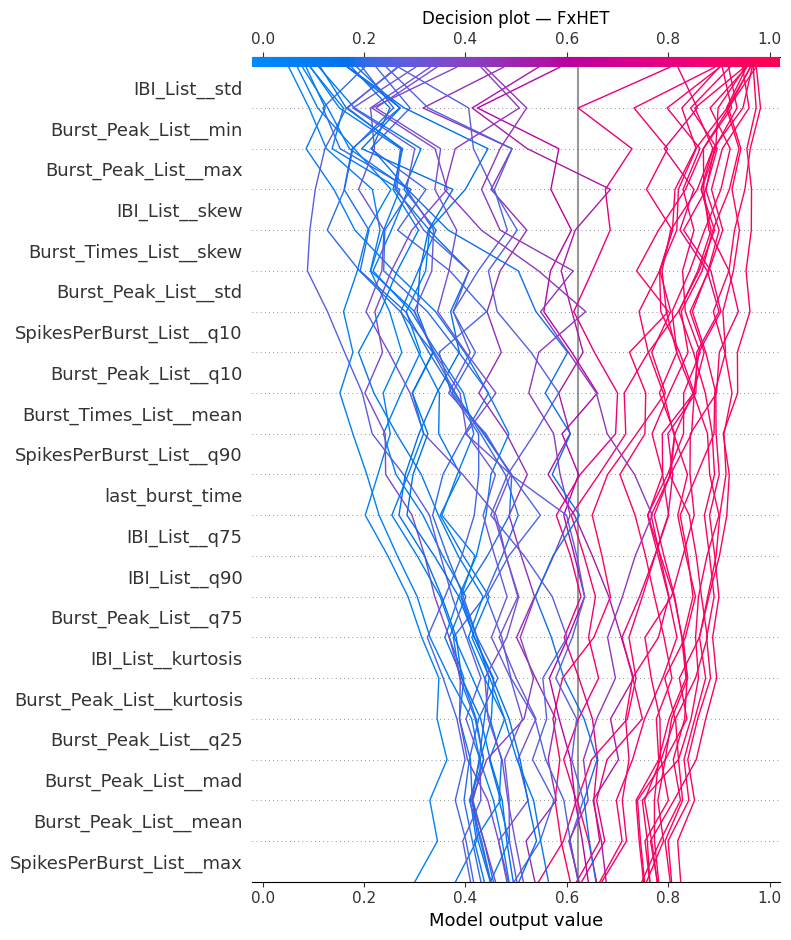

Saved: decision_FxHET.png


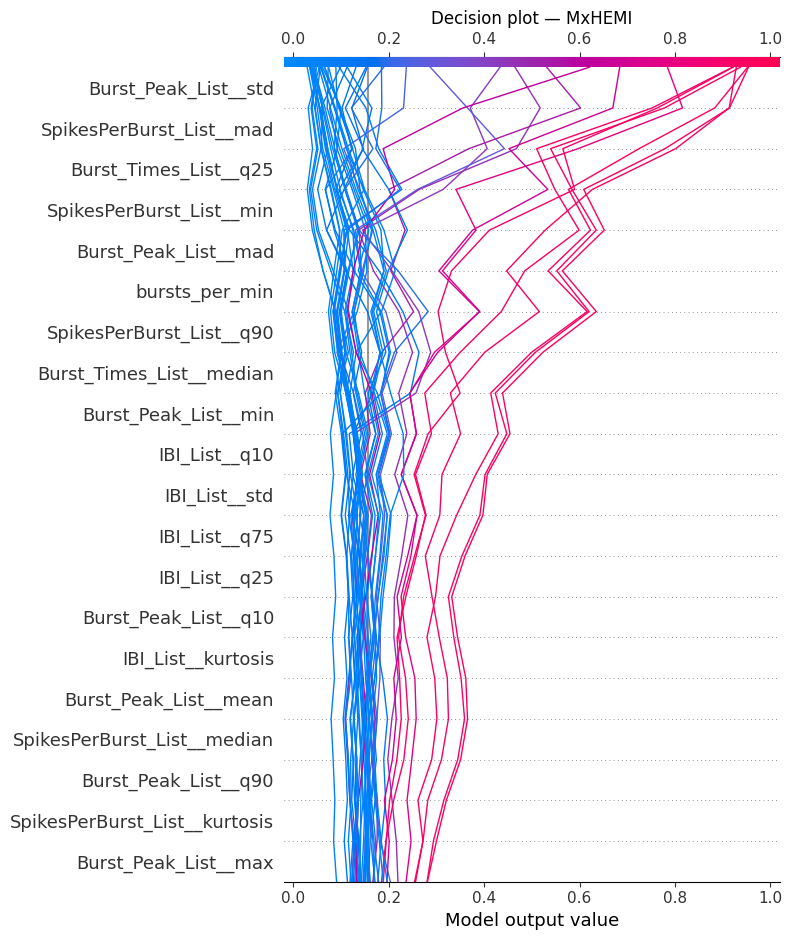

Saved: decision_MxHEMI.png


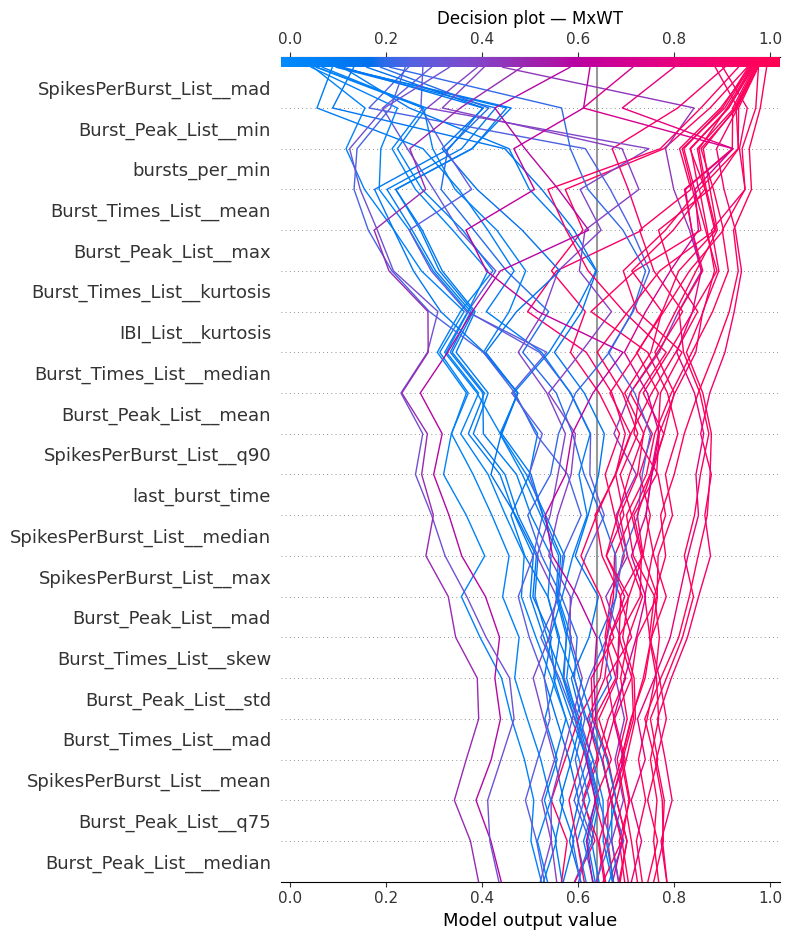

Saved: decision_MxWT.png


In [39]:
# --- SHAP decision plots for all NeuronTypes (compact) ---
import numpy as np, matplotlib.pyplot as plt, shap

feature_names = list(X_model.columns)

# Ensure eval/background + SHAP values exist
if "X_eval" not in globals():
    X_bg   = X_tr.sample(min(1000, len(X_tr)), random_state=42).astype(np.float32)
    X_eval = X_te.astype(np.float32)

if "explainer" not in globals() or "sv" not in globals():
    try:
        explainer = shap.Explainer(xgb, X_bg, feature_names=feature_names)
        sv = explainer(X_eval)                  # shap.Explanation (new API)
    except Exception:
        explainer = shap.TreeExplainer(xgb)
        sv = explainer.shap_values(X_eval)      # list per class (old API)

classes = list(le.classes_)

def _vals_base_for_class(sv_obj, ci):
    """Return (n_samples,n_features) shap matrix and a scalar base value for class ci."""
    if isinstance(sv_obj, list):  # old API
        vals = sv_obj[ci]
        base = getattr(explainer, "expected_value", 0.0)
        base = float(base[ci] if hasattr(base, "__len__") else base)
        return vals, base
    vals  = sv_obj.values
    basev = getattr(sv_obj, "base_values", None)
    if vals.ndim == 3:   # (n_samples, n_features, n_classes)
        return vals[:, :, ci], float(np.mean(basev[:, ci])) if basev is not None else 0.0
    return vals, float(np.mean(basev)) if basev is not None else 0.0

# Optional: subsample lines to keep the plot readable
N = min(200, len(X_eval))
rng = np.random.RandomState(42)
idx = rng.choice(len(X_eval), N, replace=False)

for ci, cname in enumerate(classes):
    shap_mat, base = _vals_base_for_class(sv, ci)
    shap_mat = shap_mat[idx, :]  # align to subsample
    plt.figure(figsize=(10,5))
    shap.decision_plot(base, shap_mat, feature_names=feature_names, link="logit", show=False)
    plt.title(f"Decision plot — {cname}")
    plt.tight_layout()
    out = f"decision_{cname}.png"
    plt.savefig(out, dpi=180, bbox_inches="tight")
    plt.show()
    print("Saved:", out)


# Visualizing the results in the space

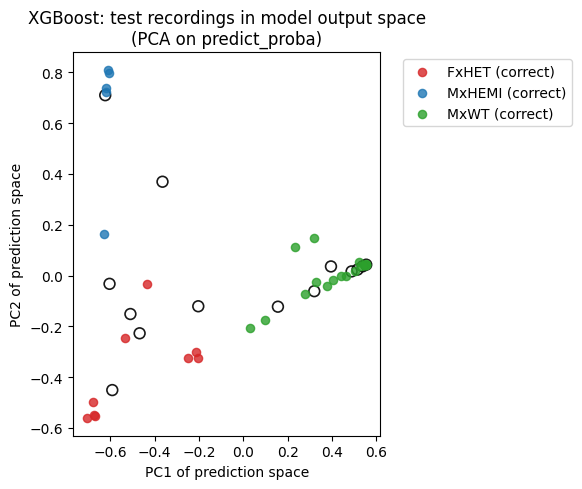

In [33]:
# =========================
# STEP 8 — Visualize model prediction space with PCA
# =========================
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1) Get class probabilities on the test set
# (works for LightGBM, XGBoost, and the MLP pipeline)
probs_te = best_model.predict_proba(X_te.astype(np.float32))  # shape (n_samples, n_classes)

# 2) Project 3D prob vectors -> 2D with PCA
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(probs_te)   # shape (n_samples, 2)

# 3) Plot: color by TRUE label, highlight misclassifications
label_names = le.classes_                        # ['FxHET','MxHEMI','MxWT'] in whatever order
n_classes = len(label_names)
colors = ["tab:red", "tab:blue", "tab:green"][:n_classes]

plt.figure(figsize=(6, 5))

for k in range(n_classes):
    mask = (y_te == k)
    # correct vs incorrect
    correct = mask & (best_pred == y_te)
    wrong   = mask & (best_pred != y_te)

    # correct points (filled)
    plt.scatter(
        Z[correct, 0], Z[correct, 1],
        s=35, alpha=0.8,
        c=colors[k],
        label=f"{label_names[k]} (correct)"
    )

    # misclassified points (same color, black edge)
    if np.any(wrong):
        plt.scatter(
            Z[wrong, 0], Z[wrong, 1],
            s=60, alpha=0.9,
            facecolors="none",
            edgecolors="k",
            linewidths=1.2,
            marker="o"
        )

plt.xlabel("PC1 of prediction space")
plt.ylabel("PC2 of prediction space")
plt.title(f"{best_name}: test recordings in model output space\n(PCA on predict_proba)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [36]:
print("\nBEST MODEL:", best_name, " | F1_macro:", reports[best_name]["f1_macro"], " | Acc:", reports[best_name]["accuracy"])



BEST MODEL: XGBoost  | F1_macro: 0.689484126984127  | Acc: 0.7021276595744681


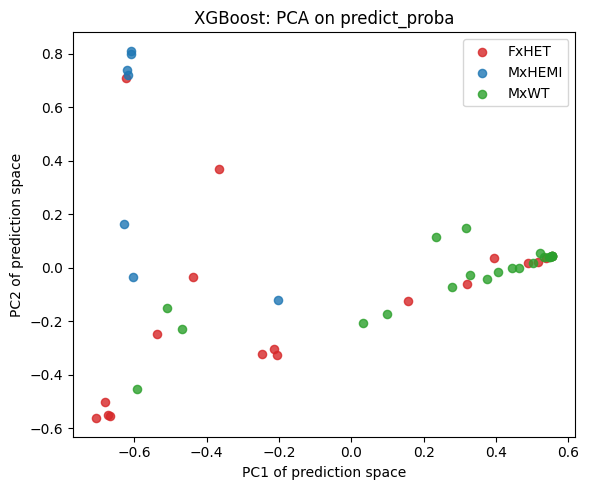

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(probs_te)   # (n_samples, 2)

plt.figure(figsize=(6, 5))
for k, cname in enumerate(label_names):
    mask = (y_true == k)
    plt.scatter(
        Z_pca[mask, 0], Z_pca[mask, 1],
        s=35, alpha=0.8, c=colors[k], label=cname
    )

plt.xlabel("PC1 of prediction space")
plt.ylabel("PC2 of prediction space")
plt.title("XGBoost: PCA on predict_proba")
plt.legend()
plt.tight_layout()
plt.show()


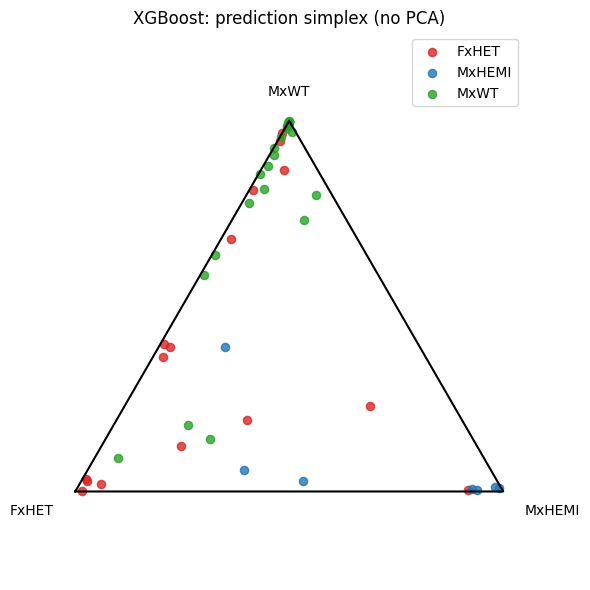

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# unpack probabilities
p_fx, p_mxh, p_mxwt = probs_te.T   # each shape (n_samples,)

# triangle vertices (equilateral)
A = np.array([0.0, 0.0])                     # FxHET corner
B = np.array([1.0, 0.0])                     # MxHEMI corner
C = np.array([0.5, np.sqrt(3)/2])            # MxWT corner

# barycentric -> Cartesian
XY = p_fx[:, None] * A + p_mxh[:, None] * B + p_mxwt[:, None] * C
x, y = XY[:, 0], XY[:, 1]

plt.figure(figsize=(6, 6))
for k, cname in enumerate(label_names):
    mask = (y_true == k)
    plt.scatter(x[mask], y[mask], s=35, alpha=0.8, c=colors[k], label=cname)

# draw triangle
plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], "k-")

plt.text(A[0] - 0.05, A[1] - 0.03, "FxHET", ha="right", va="top")
plt.text(B[0] + 0.05, B[1] - 0.03, "MxHEMI", ha="left",  va="top")
plt.text(C[0],        C[1] + 0.05, "MxWT",  ha="center", va="bottom")

plt.axis("equal")
plt.axis("off")
plt.title("XGBoost: prediction simplex (no PCA)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


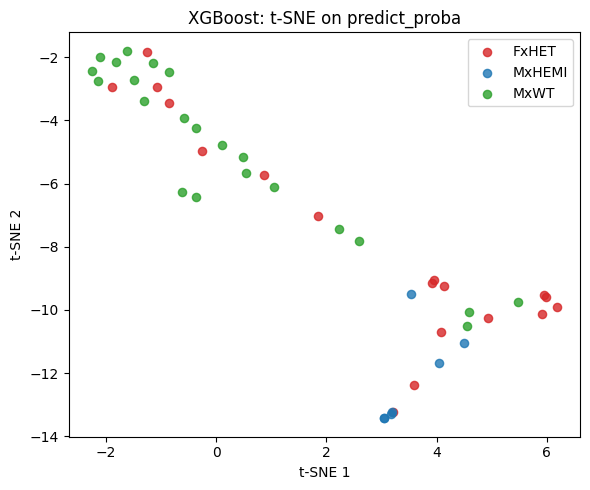

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=15,      # tweakable
    learning_rate="auto",
    init="pca",
    random_state=42,
)
Z_tsne = tsne.fit_transform(probs_te)   # (n_samples, 2)

plt.figure(figsize=(6, 5))
for k, cname in enumerate(label_names):
    mask = (y_true == k)
    plt.scatter(
        Z_tsne[mask, 0], Z_tsne[mask, 1],
        s=35, alpha=0.8, c=colors[k], label=cname
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("XGBoost: t-SNE on predict_proba")
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
pip install umap-learn

401728.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [umap-learn]
Note: you may need to restart the kernel to use updated packages.


/Users/rohan/Documents/Research/distrubution_data_ml/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


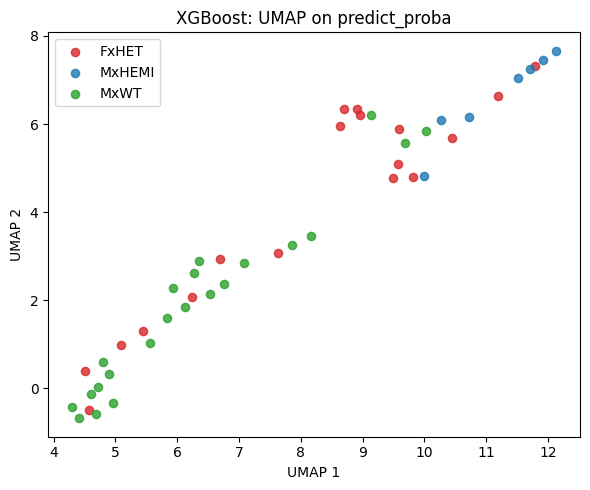

: 

In [ ]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=15,     # similar role to t-SNE perplexity
    min_dist=0.1,
)
Z_umap = reducer.fit_transform(probs_te)   # (n_samples, 2)

plt.figure(figsize=(6, 5))
for k, cname in enumerate(label_names):
    mask = (y_true == k)
    plt.scatter(
        Z_umap[mask, 0], Z_umap[mask, 1],
        s=35, alpha=0.8, c=colors[k], label=cname
    )

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("XGBoost: UMAP on predict_proba")
plt.legend()
plt.tight_layout()
plt.show()


## What this is doing (step by step)
probs_te = best_model.predict_proba(X_te.astype(np.float32))
### For each test recording, XGBoost returns
[𝑃(FxHET∣𝑥),𝑃(MxHEMI∣𝑥),𝑃(MxWT∣𝑥)]
[P(FxHET∣x), P(MxHEMI∣x), P(MxWT∣x)]
So probs_te has shape (n_test_samples, 3).
### PCA on those 3D vectors
Compresses the 3-dimensional probability vectors into 2D while preserving as much variance as possible.
Z[:, 0] and Z[:, 1] are coordinates in “model-output space.”
### Scatter plot
- Each point = one recording in the test set.
- Color = true NeuronType.
- If a class clusters nicely, the model gives similar probability patterns for that class.
- If FxHET spreads between MxHEMI and MxWT regions, that matches the confusion we saw earlier.

shap_pred shape: (47, 116)


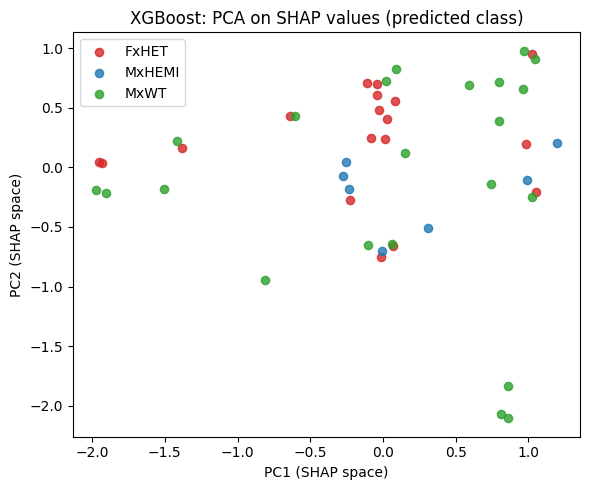

In [35]:
# =========================
# STEP 9 — Build "SHAP space" via PCA on SHAP values
# =========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

feature_names = list(X_model.columns)
class_names = list(le.classes_)   # ['FxHET', 'MxHEMI', 'MxWT']

# 1) Define evaluation set and ensure we have SHAP values for it
X_eval = X_te.astype(np.float32)
y_true = y_te

# If you already built `explainer` and `sv`, you can reuse them.
# Otherwise, rebuild here for clarity:
if "sv" not in globals():
    X_bg = X_tr.sample(min(1000, len(X_tr)), random_state=42).astype(np.float32)
    try:
        explainer = shap.Explainer(xgb, X_bg, feature_names=feature_names)
        sv = explainer(X_eval)   # new API: shap.Explanation
    except Exception:
        explainer = shap.TreeExplainer(xgb)
        sv = explainer.shap_values(X_eval)  # old API: list-of-arrays

def shap_array_for_class(sv_obj, class_idx):
    """
    Return a 2D array of SHAP values (n_samples, n_features) for a given class index,
    handling both the new shap.Explanation API and the old list-of-arrays API.
    """
    if isinstance(sv_obj, list):  # old API
        return sv_obj[class_idx]  # (n_samples, n_features)

    vals = sv_obj.values if hasattr(sv_obj, "values") else sv_obj
    if vals.ndim == 3:
        # (n_samples, n_features, n_classes)
        return vals[:, :, class_idx]
    elif vals.ndim == 2:
        # Already 2D (binary or single-output case)
        return vals
    else:
        raise ValueError(f"Unexpected SHAP array shape: {vals.shape}")

# 2) Build a SHAP matrix for the class the model actually predicts
y_pred = best_model.predict(X_eval)  # predicted class indices (0/1/2)

n_samples = X_eval.shape[0]
n_features = X_eval.shape[1]
shap_pred = np.zeros((n_samples, n_features), dtype=float)

for c in range(len(class_names)):
    mask = (y_pred == c)
    if not np.any(mask):
        continue
    shap_c = shap_array_for_class(sv, c)  # (n_samples, n_features)
    # same indexing because sv was computed on X_eval in the same order
    shap_pred[mask] = shap_c[mask]

print("shap_pred shape:", shap_pred.shape)  # (n_samples, n_features)

# 3) PCA: high-dimensional SHAP vectors -> 2D
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(shap_pred)  # (n_samples, 2)

# 4) Plot, colored by TRUE label (NeuronType)
colors = ["tab:red", "tab:blue", "tab:green"][:len(class_names)]

plt.figure(figsize=(6, 5))
for k, cname in enumerate(class_names):
    mask = (y_true == k)
    plt.scatter(
        Z[mask, 0],
        Z[mask, 1],
        s=35,
        alpha=0.8,
        c=colors[k],
        label=cname
    )

plt.xlabel("PC1 (SHAP space)")
plt.ylabel("PC2 (SHAP space)")
plt.title(f"{best_name}: PCA on SHAP values (predicted class)")
plt.legend()
plt.tight_layout()
plt.show()


## What its doing above
1. What SHAP is doing in your notebook

You have a multiclass tree model (XGBoost). For each sample 𝑥x and class 𝑘 k:
- The model produces a raw output 𝑓𝑘(𝑥) (for XGBoost this is usually log-odds / logit for class k).

